In [38]:
%matplotlib inline
import seaborn as sns, numpy as np, cPickle, pandas as pd, pylab,random,cPickle, matplotlib.pyplot as plt
from os import system,listdir
from scipy.cluster.hierarchy import fcluster,linkage,cophenet
from IPython.display import display, HTML
from os.path import join,dirname,basename,isdir
global familymatching_thresh 
from sklearn import decomposition,manifold,preprocessing,metrics
from sklearn.preprocessing import scale,normalize,StandardScaler
from scipy.stats import variation
import matplotlib.cm as cm

topdir = '/cluster/zeng/research/lineage'
familymatching_thresh = 0

## Preprocess

#### un-multiplexing analysis

Performan analysis on the number of reads corresponding to each of the 8 groups with code under 
```
/cluster/zeng/code/research/lineage/index_analysis
```

In [33]:
### Summarizing the analysis output
data= []
mynames = ['endo_t1_trans','undirect_t1_trans','endo_t2_trans','undirect_t2_trans',\
          'endo_t1_fth1','undirect_t1_fth1','endo_t2_fth1','undirect_t2_fth1','undetermined']
for idx in range(len(mynames)):
    mynames[idx] = str(idx+1)+'_'+mynames[idx]
for i in range(4):
    for j in range(1):
        with open(join(topdir,'index_analysis','lane_'+str(i+1)+'_R'+str(j+1)+'_indexsummary')) as f:
            posdata = [float(x) for x in f]
        label = '_'.join(['lane'+str(i+1)])
        sumdata = float(sum(posdata))
        data += [ [posdata[idx],mynames[idx],label] for idx in range(len(posdata))]
        data += [ [posdata[idx]/sumdata,mynames[idx],label+'_pct'] for idx in range(len(posdata))]

datapd = pd.DataFrame(data,columns=['Value','Index','Label']).pivot('Index','Label','Value')
display(datapd)

Label                   lane1  lane1_pct     lane2  lane2_pct     lane3  \
Index                                                                     
1_endo_t1_trans      14524710   0.207710  14570768   0.203794  13383757   
2_undirect_t1_trans   9402214   0.134456   9903809   0.138519   8755504   
3_endo_t2_trans       5941281   0.084963   6221703   0.087020   5412467   
4_undirect_t2_trans    237650   0.003399    282141   0.003946    235916   
5_endo_t1_fth1        2287483   0.032712   2540852   0.035538   2188699   
6_undirect_t1_fth1    6233238   0.089138   6500198   0.090915   6164407   
7_endo_t2_fth1        5553585   0.079419   5599672   0.078320   5246975   
8_undirect_t2_fth1    5187264   0.074180   5155183   0.072103   5100603   
9_undetermined       20560461   0.294024  20723293   0.289846  20063168   

Label                lane3_pct     lane4  lane4_pct  
Index                                                
1_endo_t1_trans       0.201104  13204060   0.198757  
2_undirect_t1_trans   0.131560   8130544   0.122387  
3_endo_t2_trans       0.081328   4434168   0.066746  
4_undirect_t2_trans   0.003545    207304   0.003120  
5_endo_t1_fth1        0.032887   1869695   0.028144  
6_undirect_t1_fth1    0.092626   5799872   0.087304  
7_endo_t2_fth1        0.078841   5481010   0.082504  
8_undirect_t2_fth1    0.076641   4685809   0.070534  
9_undetermined        0.301468  22620612   0.340502

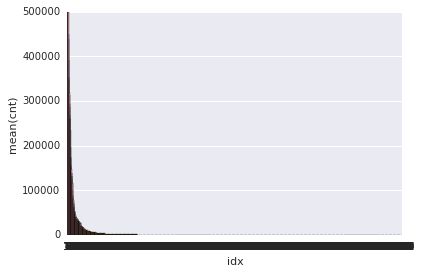

In [53]:
### Count distribution of the unmapped barcodes
with open(join(topdir,'index_analysis/unmapped.tsv')) as f:
    f.readline()
    thresh = 500000
    data = [float(x.split(',')[2]) for x in f]
    for idx in range(len(data)):
        if data[idx]> thresh:
            data[idx] = thresh
    data = pd.DataFrame([[idx,data[idx]]for idx in range(len(data))],columns=['idx','cnt'])
    sns.barplot(data=data,x='idx',y='cnt')

#### Split the reads
Split the reads into 8 groups by running
```
/cluster/zeng/code/research/lineage/splitreads/run_split_reads.sh
/cluster/zeng/code/research/lineage/splitreads/split_result/combine_6and8.sh
```

#### Run the indrop pipeline (part1)

Run 
```
python /cluster/zeng/code/research/lineage/indrops_V2/run.py 1
```
The cutoff in the second part were determined using the following elbow-point analysis

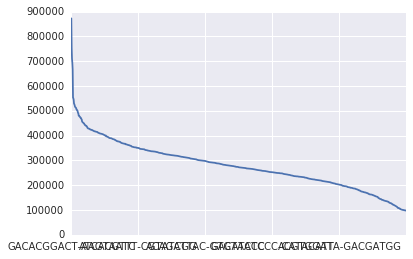

In [109]:
### Check Indrop preprocessing pipeline stats for the previous round
with open(join(t_topdir,'mESC','pre_split','barcode_read_counts.pickle'),'rb') as f:
    data = pd.Series(cPickle.load(f))
    data.sort_values(ascending=False)[:1000].plot()

Total Reads         Frac. Valid Valid Reads  Group
0    55683295  0.6281071908549952    34975078      1
1    36192071    0.56288356640326    20371922      2
2    22009619  0.6201914717378797    13650178      3
3      963011   0.508273529585851      489473      4
4     8886729  0.5635319812272884     5007956      5
5    24697715  0.6240795150482544    15413338      6
6    21881242   0.622645780344644    13624263      7
7    20128859  0.6609616074115279    13304403      8

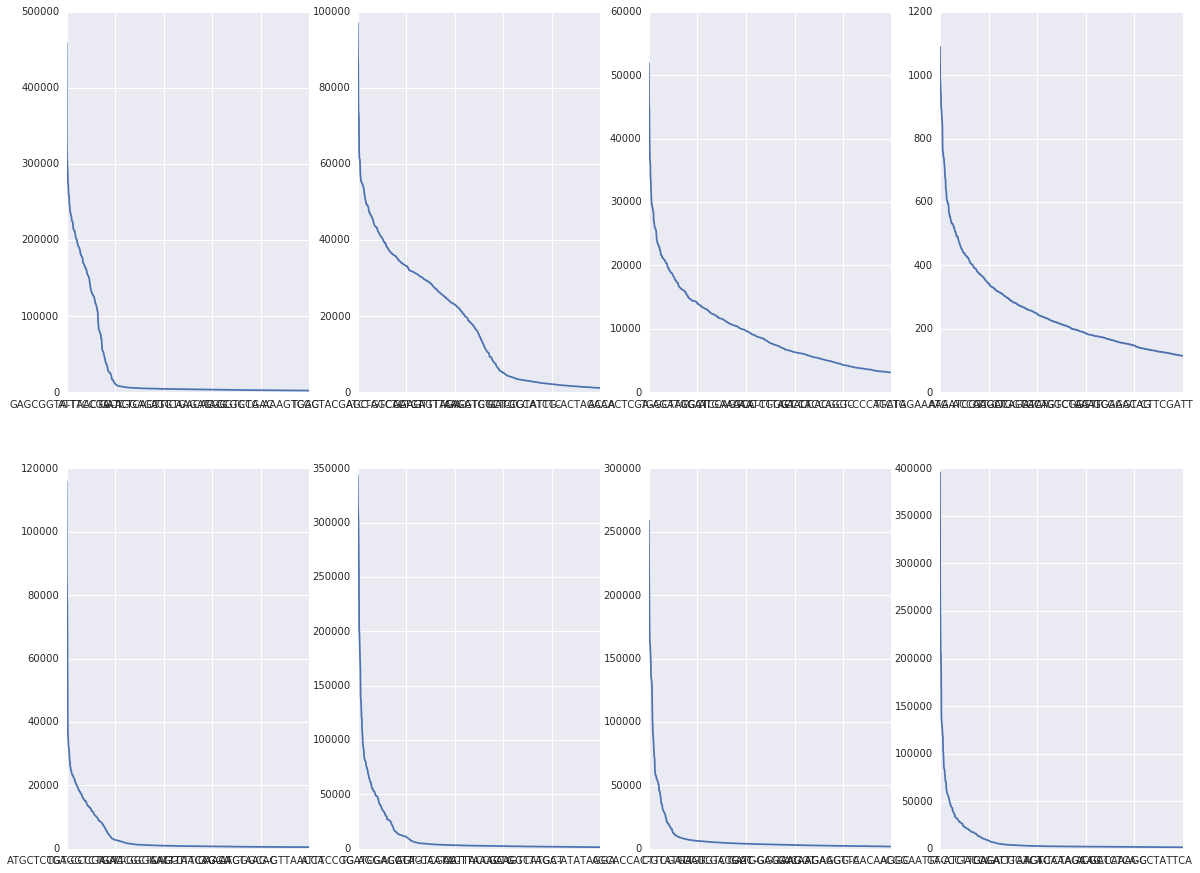

In [134]:
### Check Indrop preprocessing pipeline stats
process_stats = []
fig, axs = plt.subplots(2, 4,figsize=(20, 15))
cutoff = [10000,4000,7000,200,3000,8000,8000,6000]
for i in range(8):
    with open(join(topdir,'mESC_new'+str(i+1),'pre_split','barcode_read_counts.pickle'),'rb') as f:
        data = pd.Series(cPickle.load(f))
    data.sort_values(ascending=False)[:1000].plot(ax=axs[i/4][i%4])
    #plt.figure()
    #data.sort_values(ascending=False)[:1000].plot()
    #plt.plot(range(1000), [cutoff[i]]*1000)
    with open(join(topdir,'mESC_new'+str(i+1),'stats/filtering_metrics.yaml')) as f:
        data = [x.strip().split(': ') for x in f]
        process_stats.append([ data[-3][1],data[-2][1],data[-1][1],i+1])

display(pd.DataFrame(process_stats,columns=['Total Reads','Frac. Valid','Valid Reads','Group']))

Total Reads         Frac. Valid Valid Reads  Group
0    44826574  0.6406409956736823    28717741      1

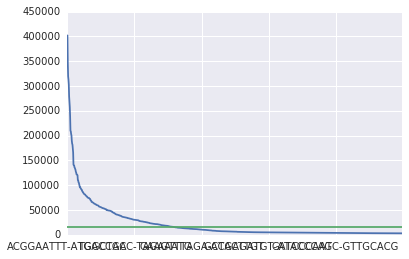

In [428]:
### Check Indrop preprocessing pipeline stats
process_stats = []
cutoff = [15000]
with open(join(topdir,'mESC_fth1_timeboth_rep2','pre_split','barcode_read_counts.pickle'),'rb') as f:
    data = pd.Series(cPickle.load(f))
plt.figure()
data.sort_values(ascending=False)[:1000].plot()
plt.plot(range(1000), [cutoff[0]]*1000)
with open(join(topdir,'mESC_fth1_timeboth_rep2','stats/filtering_metrics.yaml')) as f:
    data = [x.strip().split(': ') for x in f]
    process_stats.append([ data[-3][1],data[-2][1],data[-1][1],1])

display(pd.DataFrame(process_stats,columns=['Total Reads','Frac. Valid','Valid Reads','Group']))

#### Run the indrop pipeline (part2)

Based on the figures above, pick a reasonable read cutoff for each experiment. Change the cutoff parameter in the following script accordingly and run 
```
python /cluster/zeng/code/research/lineage/indrops_V2/run.py 2
```

In [124]:
# check the number of cells (droplets) left with the above cutoffs
display(pd.DataFrame([ len([name for name in listdir(topdir,'mESC_new' +str(i+1)+'/post_split/filtered_fastq')
            if not isdir(join(topdir,'mESC_new'\
                            +str(i+1)+'/post_split/filtered_fastq', name))]) for i in range(8)],columns=['#cell']))

#cell
0    205
1    635
2    551
3    545
4    196
5    218
6    144
7    232

## Extract lineage barcode
Run 
```
/cluster/zeng/code/research/lineage/run.sh
```

## Barcode filtering and family analysis

In [335]:
def listdist(seqs1,seqs2,dist_thresh):
    ### If any element of seqs1 matches any element of seq2, we call it a match
    for idx1 in range(len(seqs1)):
        for idx2 in range(len(seqs2)):
            t_dist = dist(seqs1[idx1],seqs2[idx2])
            if t_dist <= dist_thresh:
                return 0
    return 1

In [458]:
def analysis2(mappingfile,family_analysis,barcode2filter,pe2readthresh):
    datacode = mappingfile.split('.raw.tsv')[0]
    
    ### Read the mapping result
    oridata = pd.read_csv(mappingfile,sep ='\t',dtype =\
                          {'barcodecnt':int,'barcode_moleculecnt':int,'readcnt':int,'moleculecnt':int})
    oridata['barcodes'] = oridata['barcodes'].apply(lambda x: np.asarray(x.split(',')))
    oridata['barcodereads_split'] = oridata['barcodereads_split'].apply(lambda x: np.asarray(map(int,x.split(','))))
    ori_barcode_coverage = pd.Series([ y for x in oridata['barcodes'] for y in x]).value_counts()
    ori_barcode_coverage.to_csv(datacode+'.bcCoverage.thresh'+str(pe2readthresh),sep='\t')
    
    ### For each cell, retain only the first two barcode with a threshold cutoff
    data = oridata.copy(deep=True)
    for index, row in data.iterrows():
        t_bc_read_cnt = row['barcodereads_split']
        topick = [x for x in np.argsort(t_bc_read_cnt)[-2:][::-1] if t_bc_read_cnt[x]>pe2readthresh]
        if len(topick) == 2:
            if t_bc_read_cnt[topick[1]] < t_bc_read_cnt[topick[0]]/2.0:
                topick = [topick[0]]
        if len(topick)>0:
            data.set_value(index,'barcodes',row['barcodes'][topick])
            data.set_value(index,'barcodereads_split',t_bc_read_cnt[topick])
            data.set_value(index,'barcode_moleculecnt',sum(t_bc_read_cnt[topick]))
            data.set_value(index,'barcodecnt',len(topick))
        else:
            data.set_value(index,'barcodes',['\\'])
    data['barcodes'] = data['barcodes'].apply(lambda x:','.join(x))
    
    barcode_coverage = pd.Series([ y for x in data['barcodes'] for y in x.split(',')]).value_counts()
    barcode_coverage.to_csv(datacode+'.bcCoverage.postfilter.thresh'+str(pe2readthresh),sep='\t')
    bi_barcode_coverage = pd.Series([ ','.join(np.sort(x.split(','))) for x in data['barcodes'] ]).value_counts()
    bi_barcode_coverage.to_csv(datacode+'.bcCoverage.postfilter.bi.thresh'+str(pe2readthresh),sep='\t')
    
    stats= [['# of reads',oridata['readcnt'].sum()],\
            ['# of transcript molecules (unique UMI)',oridata['moleculecnt'].sum()],\
            ['# of transcript molecules (unique UMI) w. bc',oridata['barcode_moleculecnt'].sum()],\
            ['# of cells',len(oridata)],\
            ['# of barcodes',len(ori_barcode_coverage)],\
            ['# of cells after processing',len(data[data['barcodes']!= '\\'])],\
            ['# of barcodes after processing',len(barcode_coverage)],\
            ['# of barcodes after processing (concat two bc)',len(bi_barcode_coverage)],\
            ]
    summary = pd.DataFrame([[x[0],x[1]] for x in stats],columns=['Item','Num'])
    
    ### Family analysis
    family_summary = family2(data[data['barcodes']!= '\\'],[datacode+'.familyanalysis-cellcentric'+\
                             '.thres'+str(pe2readthresh)+'.csv',datacode+'.familyanalysis-aggregated'+\
                             '.thres'+str(pe2readthresh)+'.csv']) if family_analysis else None
        
    return summary,family_summary

In [462]:
def reorder(x):
    t_barcodes = x['barcodes'].split(',')
    pick = np.argsort(t_barcodes)
    x['barcodes'] = ','.join([t_barcodes[y] for y in pick])
    x['barcodereads_split'] = [x['barcodereads_split'][y] for y in pick]
    return x

def family2(data,outfiles):
    num_data = len(data)
    data.index = range(num_data)
    
    cond_dist = [listdist(data.get_value(idx1,'barcodes').split(','),data.get_value(idx2,'barcodes').split(','),\
                          familymatching_thresh) for idx1 in range(num_data-1) for idx2 in range(idx1+1,num_data)]
    link = linkage(cond_dist,method='single')
    data['lineage'] = pd.Series(fcluster(link,0.5,criterion='distance')-1,index=data.index)
    data = data.sort_values(by='lineage').apply(lambda x: reorder(x),axis=1)
    data.to_csv(outfiles[0],index=False)
    
    lineage_info = []
    for name, group in data.groupby('lineage'):
        vc = group['barcodes'].value_counts()
        for idx,x in enumerate(vc):
            lineage_info.append([name,vc.index[idx],x])
                      
    pd.DataFrame(lineage_info,columns=['Lineage','Barcodes','Cnt']).to_csv(outfiles[1])
    
    stats= [['# of cells included in family analysis',num_data] ,\
            ['# of lineages',len(data['lineage'].unique())],\
            ['Size of lineages',list(data['lineage'].value_counts())]
             ]
    summary = pd.DataFrame([[x[0],x[1]] for x in stats],columns=['Item','Num'])
    return summary

In [463]:
### fth1 integrated barcodes
for t_thresh in [1,3,10]:
    allsummary = None
    allsummary_family = None
    for idx, expt in enumerate(['mESC_fth1_time1_rep1','mESC_fth1_time1_rep2','mESC_fth1_time2_rep1','mESC_fth1_time2_rep2','mESC_fth1_timeboth_rep2']):
        mappingfile = join(topdir,expt,'post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2.raw.tsv')
        t_s,t_family = analysis2(mappingfile,True,[],t_thresh)
        t_s.columns = ['Item',expt]
        t_family.columns = ['Item',expt]
        allsummary = t_s if allsummary is None else allsummary.merge(t_s,on='Item')
        allsummary_family = t_family if allsummary_family is None else allsummary_family.merge(t_family,on='Item')
    combined = allsummary.append(allsummary_family)
    combined['Thresh'] = pd.Series(t_thresh,index=combined.index)
    display(combined)
    combined.to_csv(join(topdir,'fth1.stats.thresh'+str(t_thresh)+'.csv'),index=False)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Item mESC_fth1_time1_rep1  \
0                                      # of reads              2998912   
1          # of transcript molecules (unique UMI)               173648   
2    # of transcript molecules (unique UMI) w. bc                 1914   
3                                      # of cells                  196   
4                                   # of barcodes                   16   
5                     # of cells after processing                  122   
6                  # of barcodes after processing                    4   
7  # of barcodes after processing (concat two bc)                    4   
0          # of cells included in family analysis                  122   
1                                   # of lineages                    3   
2                                Size of lineages          [119, 2, 1]   

               mESC_fth1_time1_rep2 mESC_fth1_time2_rep1  \
0                          10967607              6146482   
1                            128075               135995   
2                             72559                36020   
3                               218                  144   
4                               385                  118   
5                               218                  144   
6                                13                    7   
7                                17                    7   
0                               218                  144   
1                                 9                    4   
2  [166, 14, 11, 10, 6, 5, 3, 2, 1]       [133, 5, 4, 2]   

    mESC_fth1_time2_rep2    mESC_fth1_timeboth_rep2  Thresh  
0                8027986                   18220548       1  
1                 173619                     509308       1  
2                 114088                     140148       1  
3                    232                        324       1  
4                    308                        522       1  
5                    232                        324       1  
6                     12                         13       1  
7                     17                         20       1  
0                    232                        324       1  
1                      6                          7       1  
2  [211, 11, 5, 3, 1, 1]  [263, 27, 14, 8, 5, 4, 3]       1

Item mESC_fth1_time1_rep1  \
0                                      # of reads              2998912   
1          # of transcript molecules (unique UMI)               173648   
2    # of transcript molecules (unique UMI) w. bc                 1914   
3                                      # of cells                  196   
4                                   # of barcodes                   16   
5                     # of cells after processing                   57   
6                  # of barcodes after processing                    2   
7  # of barcodes after processing (concat two bc)                    2   
0          # of cells included in family analysis                   57   
1                                   # of lineages                    1   
2                                Size of lineages                 [57]   

               mESC_fth1_time1_rep2 mESC_fth1_time2_rep1  \
0                          10967607              6146482   
1                            128075               135995   
2                             72559                36020   
3                               218                  144   
4                               385                  118   
5                               217                  143   
6                                14                    7   
7                                18                    7   
0                               217                  143   
1                                 9                    4   
2  [165, 14, 11, 10, 6, 5, 3, 2, 1]       [132, 5, 4, 2]   

    mESC_fth1_time2_rep2    mESC_fth1_timeboth_rep2  Thresh  
0                8027986                   18220548       3  
1                 173619                     509308       3  
2                 114088                     140148       3  
3                    232                        324       3  
4                    308                        522       3  
5                    232                        324       3  
6                     12                         13       3  
7                     17                         20       3  
0                    232                        324       3  
1                      6                          7       3  
2  [211, 11, 5, 3, 1, 1]  [263, 27, 14, 8, 5, 4, 3]       3

Item mESC_fth1_time1_rep1  \
0                                      # of reads              2998912   
1          # of transcript molecules (unique UMI)               173648   
2    # of transcript molecules (unique UMI) w. bc                 1914   
3                                      # of cells                  196   
4                                   # of barcodes                   16   
5                     # of cells after processing                    8   
6                  # of barcodes after processing                    2   
7  # of barcodes after processing (concat two bc)                    2   
0          # of cells included in family analysis                    8   
1                                   # of lineages                    1   
2                                Size of lineages                  [8]   

               mESC_fth1_time1_rep2 mESC_fth1_time2_rep1  \
0                          10967607              6146482   
1                            128075               135995   
2                             72559                36020   
3                               218                  144   
4                               385                  118   
5                               217                  143   
6                                14                    7   
7                                18                    7   
0                               217                  143   
1                                 9                    4   
2  [165, 14, 11, 10, 6, 5, 3, 2, 1]       [132, 5, 4, 2]   

    mESC_fth1_time2_rep2    mESC_fth1_timeboth_rep2  Thresh  
0                8027986                   18220548      10  
1                 173619                     509308      10  
2                 114088                     140148      10  
3                    232                        324      10  
4                    308                        522      10  
5                    232                        324      10  
6                     12                         13      10  
7                     17                         20      10  
0                    232                        324      10  
1                      6                          7      10  
2  [211, 11, 5, 3, 1, 1]  [263, 27, 14, 8, 5, 4, 3]      10

In [385]:
### fth1 barcodelet
for t_thresh in [1,3,10]:
    allsummary = None
    allsummary_family = None
    for expt in ['mESC_fth1_time1_rep1','mESC_fth1_time1_rep2','mESC_fth1_time2_rep1','mESC_fth1_time2_rep2']:
        mappingfile = join(topdir,expt,'post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2.barcodelet')
        t_s,t_family = analysis2(mappingfile,False,[],t_thresh)
        t_s.columns = ['Item',expt]
        allsummary = t_s if allsummary is None else allsummary.merge(t_s,on='Item')
    allsummary['Thresh'] = pd.Series(t_thresh,index=allsummary.index)
    display(allsummary)
    allsummary.to_csv(join(topdir,'barcodelet.stats.thresh'+str(t_thresh)+'.csv'),index=False)

Item  mESC_fth1_time1_rep1  \
0                                      # of reads               2998912   
1          # of transcript molecules (unique UMI)                173648   
2    # of transcript molecules (unique UMI) w. bc                   296   
3                                      # of cells                   196   
4                                   # of barcodes                    77   
5                     # of cells after processing                    63   
6                  # of barcodes after processing                    25   
7  # of barcodes after processing (concat two bc)                    27   

   mESC_fth1_time1_rep2  mESC_fth1_time2_rep1  mESC_fth1_time2_rep2  Thresh  
0              10967607               6146482               8027986       1  
1                128075                135995                173619       1  
2                   103                   228                   115       1  
3                   218                   144                   232       1  
4                    40                    67                    60       1  
5                    18                    37                    13       1  
6                    12                    24                     6       1  
7                    11                    23                     6       1

Item  mESC_fth1_time1_rep1  \
0                                      # of reads               2998912   
1          # of transcript molecules (unique UMI)                173648   
2    # of transcript molecules (unique UMI) w. bc                   296   
3                                      # of cells                   196   
4                                   # of barcodes                    77   
5                     # of cells after processing                    12   
6                  # of barcodes after processing                     8   
7  # of barcodes after processing (concat two bc)                     8   

   mESC_fth1_time1_rep2  mESC_fth1_time2_rep1  mESC_fth1_time2_rep2  Thresh  
0              10967607               6146482               8027986       3  
1                128075                135995                173619       3  
2                   103                   228                   115       3  
3                   218                   144                   232       3  
4                    40                    67                    60       3  
5                     1                    14                     0       3  
6                     2                     5                     1       3  
7                     2                     5                     1       3

Item  mESC_fth1_time1_rep1  \
0                                      # of reads               2998912   
1          # of transcript molecules (unique UMI)                173648   
2    # of transcript molecules (unique UMI) w. bc                   296   
3                                      # of cells                   196   
4                                   # of barcodes                    77   
5                     # of cells after processing                     0   
6                  # of barcodes after processing                     1   
7  # of barcodes after processing (concat two bc)                     1   

   mESC_fth1_time1_rep2  mESC_fth1_time2_rep1  mESC_fth1_time2_rep2  Thresh  
0              10967607               6146482               8027986      10  
1                128075                135995                173619      10  
2                   103                   228                   115      10  
3                   218                   144                   232      10  
4                    40                    67                    60      10  
5                     0                     0                     0      10  
6                     1                     1                     1      10  
7                     1                     1                     1      10

## Transcriptome analysis

#### Run the step 3 and 4 of Indrop pipeline to map the transcripts

Run 

```
    cd /cluster/zeng/code/research/lineage/indrops_V2/indrops/
    python run.py 3   (It will instruct you how to qsub the jobs output to a folder)
    python run.py 4
    
```

#### Construct a dictionary that maps droplet-cell barcode to lineage using the results from the above analysis of fth1 barcodes

In [492]:
lineage_assignment = pd.read_csv(join(topdir,'mESC_fth1_timeboth_rep2/post_split/final_lineage_assignment.csv'))

for expt in ['mESC_fth1_time1_rep2','mESC_fth1_time2_rep2']:
    cellbc2lineage = dict()
    with open(join(topdir,expt,'pre_split/good_barcodes_with_names.pickle'),'rb') as f:
        cellbc2name = cPickle.load(f)
    name2lineagebc = pd.read_csv(join(topdir,expt,'post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2.familyanalysis-cellcentric.thres10.csv'))
    for idx,key in enumerate(cellbc2name.keys()) :
        t_row = name2lineagebc[name2lineagebc['cell']==cellbc2name[key]]['barcodes']
        if len(t_row>0):
            t_barcodes = ','.join(np.sort(t_row.iloc[0].split(',')))
            t_lineage = lineage_assignment[lineage_assignment['Barcodes']==t_barcodes]['Lineage']
            if len(t_lineage) > 0:
                cellbc2lineage[key] = t_lineage.iloc[0]
                with open(join(topdir,expt,'post_split','cellbc2lineage.pkl'),'wb') as f:
                    cPickle.dump(cellbc2lineage,f)

#### Take a look the expression data

In [2]:
def loadexpr(datafiles,cellmapper):
    with open(datafiles[0]) as f1,open(datafiles[1]) as f2:
        fulldata_raw = [x.strip().split('\t') for x in f1]
        ambidata_raw = [x.strip().split('\t') for x in f2]
        fulldata = np.asarray([map(float,x[4:]) for x in fulldata_raw[1:]]).transpose()
        ambidata = np.asarray([map(float,x[4:]) for x in ambidata_raw[1:]]).transpose()
        data = fulldata - ambidata
    print 'shape of expression matrix',data.shape
    cells = fulldata_raw[0][4:]
    lineageinfo = ['others' if cellmapper[t_cell]=='NA' else str(cellmapper[t_cell])\
                   for t_idx,t_cell in enumerate(cells)]
    return { 'data':data,'genes':[x[0] for x in fulldata_raw[1:]],'lineageinfo':lineageinfo}

In [3]:
### Load expression data
expr_data = dict()
summary = []
for t_expt_trans in ['mESC_trans_time1_rep2','mESC_trans_time2_rep2']:
    t_expt_fth1 = t_expt_trans.replace('trans','fth1')
    with open(join(topdir,t_expt_fth1,'post_split','cellbc2lineage.pkl'),'rb') as f:
        cellbc2lineage = cPickle.load(f)
    with open(join(topdir,t_expt_trans,'pre_split/good_barcodes_with_names.pickle'),'rb') as f:
        cellbc2name = cPickle.load(f)

    t_mapper = dict()
    t_table = []
    for idx,key in enumerate(cellbc2name.keys()):
        t_lineage = cellbc2lineage[key] if key in cellbc2lineage.keys() else 'NA'
        t_mapper[cellbc2name[key]] = t_lineage
        t_table.append([cellbc2name[key],t_lineage])
    t_value_cnt = pd.DataFrame(t_table,columns=['name','lineage'])['lineage'].value_counts()
    t_datafiles = [join(topdir,t_expt_trans,'aggregated_counts/full_counts.txt'),\
                        join(topdir,t_expt_trans,'aggregated_counts/ambig_counts.txt')]
    expr_data[t_expt_trans] = loadexpr(t_datafiles,t_mapper)
    summary += [[t_value_cnt.index[idx],x,t_expt_trans] for idx,x in enumerate(t_value_cnt)]

pd.pivot_table(pd.DataFrame(summary,columns=['Lineage','cell cnt','Expt']),\
               values='cell cnt',index='Lineage',columns='Expt')

shape of expression matrix (635, 28662)
shape of expression matrix (545, 28662)


Expt     mESC_trans_time1_rep2  mESC_trans_time2_rep2
Lineage                                              
0                            5                      9
1                            9                      3
2                            3                    NaN
3                           15                     15
4                            3                      2
5                            5                    NaN
6                           82                     84
7                           34                     18
8                           18                      2
NA                         461                    412

Fraction of cells with any gene expression at all 1.0
Fraction of cells with any gene expression at all 1.0


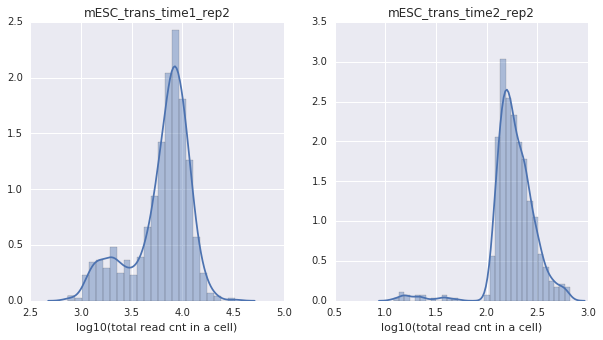

In [4]:
### Cell-centric analysis
fig, axs = plt.subplots(1, 2,figsize=(10, 5))
for idx,t_expt_trans in enumerate(['mESC_trans_time1_rep2','mESC_trans_time2_rep2']):
    t_cell_cnt = np.sum(expr_data[t_expt_trans]['data'],axis=1)
    g = sns.distplot(pd.Series(np.log10(t_cell_cnt+0.1),name='log10(total read cnt in a cell)'),ax=axs[idx])
    g.set_title(t_expt_trans)
    print 'Fraction of cells with any gene expression at all',len([1 for x in t_cell_cnt if x>0])/float(len(t_cell_cnt))

mESC_trans_time1_rep2
Num of genes 28662
Fraction of gene expressed at all 0.913474286512
mESC_trans_time2_rep2
Num of genes 28662
Fraction of gene expressed at all 0.441699811597


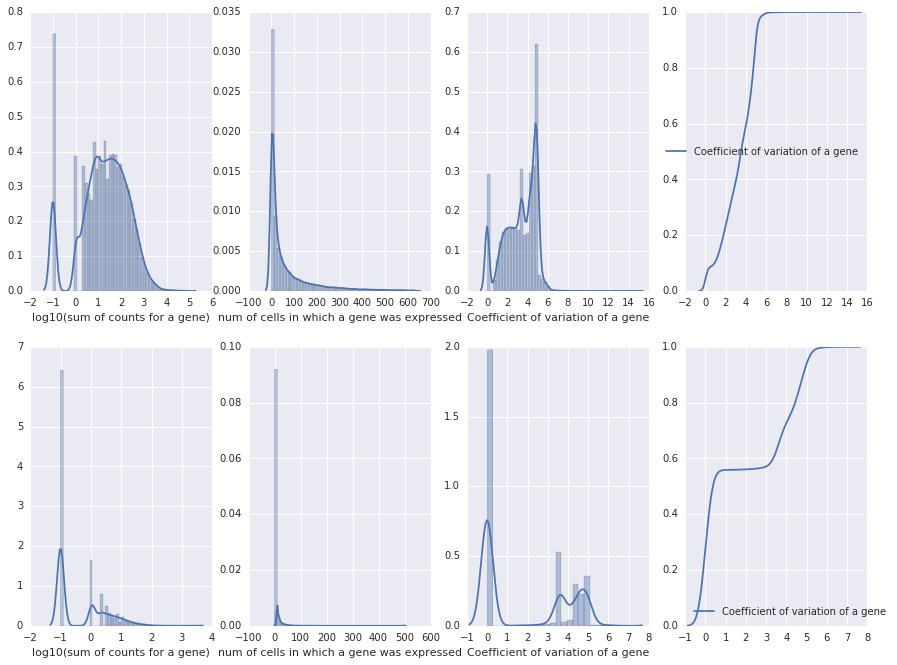

In [5]:
### Gene-centric analysis
fig, axs = plt.subplots(2, 4,figsize=(15, 11))
myvariation = dict()
mycellexpressed = dict()
for t_idx,t_expt_trans in enumerate(['mESC_trans_time1_rep2','mESC_trans_time2_rep2']):
    print t_expt_trans
    mydata = np.copy(expr_data[t_expt_trans]['data'])
    t_gene_cnt = np.sum(mydata,axis=0)
    print 'Num of genes',len(t_gene_cnt)
    print 'Fraction of gene expressed at all',len([1 for x in t_gene_cnt if x>0])/float(len(t_gene_cnt))
    sns.distplot(pd.Series(np.log10(t_gene_cnt+0.1),name='log10(sum of counts for a gene)'),ax=axs[t_idx][0])

    mycellexpressed[t_expt_trans] = [ np.count_nonzero(x) for x in mydata.transpose()]
    sns.distplot(pd.Series(mycellexpressed[t_expt_trans],\
                           name='num of cells in which a gene was expressed'),ax=axs[t_idx][1])

    for idx,x in enumerate(mydata.transpose()):
        mydata[:,idx] += 0.01
    myvariation[t_expt_trans] = pd.Series(variation(mydata,axis=0),name='Coefficient of variation of a gene')
    sns.distplot(myvariation[t_expt_trans],ax=axs[t_idx][2])
    sns.kdeplot(myvariation[t_expt_trans],cumulative=True,ax=axs[t_idx][3])

In [7]:
def mynormalizer(data):
    return StandardScaler().fit_transform(normalize(np.log10(data+0.1), axis=1, norm='l1'))

def mynormalizer2(data):
    return StandardScaler().fit_transform(normalize(data, axis=1, norm='l1'))
def mynormalizer3(data):
    return normalize(normalize(np.log10(data+0.1), axis=1, norm='l1'), axis=1, norm='l1')

def mynormalizer4(data):
    return normalize(np.log10(data+0.1), axis=1, norm='l1')

data shape (635, 2089)
data shape (545, 483)


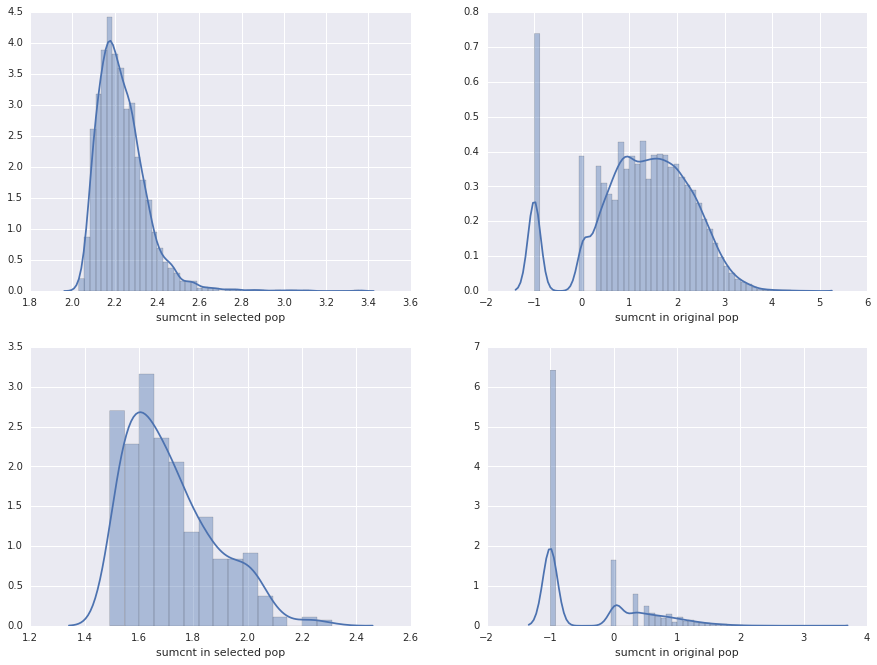

In [8]:
### Retain only genes with high CV and enough readcounts
mynormalizer_here = mynormalizer
myCV_cutoff = [2,2]
mycellexpressed_cutoff = [100,30]
fig, axs = plt.subplots(2, 2,figsize=(15, 11))
for t_idx,t_expt_trans in enumerate(['mESC_trans_time1_rep2','mESC_trans_time2_rep2']):
    mydata = expr_data[t_expt_trans]['data'].transpose()
    myreadsum = np.sum(mydata,axis=1)
    filtered_pick =[idx for idx,x in enumerate(mydata) if myvariation[t_expt_trans][idx]>myCV_cutoff[t_idx] \
                      and mycellexpressed[t_expt_trans][idx]> mycellexpressed_cutoff[t_idx]]
    
    expr_data_filtered = mydata[filtered_pick].transpose()
    print 'data shape',expr_data_filtered.shape
    expr_data[t_expt_trans+'_top'] =  dict()
    expr_data[t_expt_trans+'_top']['data'] = expr_data_filtered
    expr_data[t_expt_trans+'_top']['data_norm'] = mynormalizer_here(expr_data_filtered)
    expr_data[t_expt_trans+'_top']['lineageinfo'] = expr_data[t_expt_trans]['lineageinfo']
    expr_data[t_expt_trans+'_top']['genes'] = np.asarray(expr_data[t_expt_trans]['genes'])[filtered_pick]
    mysum = np.log10(np.sum(mydata,axis=1)+0.1)
    sns.distplot( pd.Series([ mysum[x]  for x in filtered_pick],name='sumcnt in selected pop'),ax=axs[t_idx][0])
    sns.distplot(pd.Series(mysum,name='sumcnt in original pop'),ax=axs[t_idx][1])
    
    expr_data[t_expt_trans]['data_norm'] = mynormalizer_here(expr_data[t_expt_trans]['data'])

#### PCA analysis

In [49]:
def oneVothers(unique_family,Y,lineageinfo):
    t_data = []
    for t_idx,lineage in enumerate(unique_family):
        if lineage != 'others':
            t_data += [[Y[idx][0],Y[idx][1],'this',lineage] if lineageinfo[idx]==lineage \
                      else [Y[idx][0],Y[idx][1],'others',lineage] for idx in range(len(Y))]
    sns.lmplot(x='d1',y='d2',hue='label',col='lineage',col_wrap=3,palette ="Set1",
               data=pd.DataFrame(t_data,columns=['d1','d2','label','lineage']),fit_reg =False)
    plt.show()

def justone(Y,lineageinfo):
    annotatelist = np.asarray([[x,Y[idx][0],Y[idx][1]] for idx,x in enumerate(lineageinfo) if x!='others' ])
    lmplot([[Y[idx][0],Y[idx][1],lineageinfo[idx]]for idx in range(len(Y))],'d1','d2','lineage',\
           sns.color_palette("hls", len(np.unique(lineageinfo))),True,annotatelist)
    
def PCAanalysis(exprdata):
    unique_family = np.unique(exprdata['lineageinfo'])
    lineage_num = len(unique_family)
    
    Y = dict()
    t_pca = decomposition.PCA(n_components=2).fit(exprdata['data_norm'])
    for pc_idx in range(2):
        print 'Top contributors of the {0} PC'.format(pc_idx+1)
        print np.asarray(exprdata['genes'])[np.abs(t_pca.components_[pc_idx]).argsort()[-50:]]
        t_file = 'pc{}_top50gene.txt'.format(pc_idx)
        print 'Saved to',t_file
        np.savetxt(t_file,np.asarray(exprdata['genes'])[np.abs(t_pca.components_[pc_idx]).argsort()[-50:]],'%s')
    Y['PCA'] = t_pca.transform(exprdata['data_norm'])
    Y['t-SNE'] = manifold.TSNE(n_components=2, init='pca', random_state=0,perplexity=5).\
                                fit_transform(exprdata['data_norm'])
    Y['Isomap'] = manifold.Isomap(5, 2).fit_transform(exprdata['data_norm'])
    
    for dtype in ['PCA','t-SNE','Isomap']:
        print '### {} analasis ###'.format(dtype)
        justone(Y[dtype],exprdata['lineageinfo'])
        oneVothers(unique_family,Y[dtype],exprdata['lineageinfo'])
        silhouette_test(Y[dtype],exprdata['lineageinfo'])

def lmplot(data,d1,d2,hue,colors,annotate,label_data):
    d = pd.DataFrame(data,columns=[d1,d2,hue])
    if  colors == '':
        sns.lmplot(d1,d2, data=d, hue=hue, fit_reg=False)
    else:
        sns.lmplot(d1,d2, data=d, hue=hue, fit_reg=False,palette=colors)  
   
    if annotate:
        for label, x, y in label_data:
            plt.annotate(
                label,
                xy = (x, y), xytext = mycircle(20,random.uniform(1,360)),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    pylab.show()
def mycircle(radius,degree):
    return radius * np.sin(2*np.pi*degree/360), radius*np.cos(2*np.pi*degree/360)

def permtest(X,Y,n):
    ori_score = metrics.silhouette_score(X, Y, metric='euclidean')
    print 'mean Silhouette Coefficient:',ori_score
    cnt = 0
    for i in range(n):
        random.shuffle(Y)
        t_score = metrics.silhouette_score(X, Y, metric='euclidean')
        if t_score > ori_score:
            cnt += 1
    print 'P-value of Silhouette Coefficient: p=', float(cnt) / n

def silhouette_test(Y,lineageinfo):
    pick = [ idx for idx,x in enumerate(lineageinfo) if x!='others' ]
    X = Y[pick]
    cluster_labels = np.asarray(lineageinfo)[pick]
    permtest(X,cluster_labels,1000)
    
    sample_silhouette_values = metrics.silhouette_samples(X,cluster_labels)
    fig, (ax1) = plt.subplots(1, 1)
    y_lower = 10
    n_clusters = len(np.unique(cluster_labels))
    for i in np.unique(cluster_labels):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

##### Are the expression patterns between the two time points different?

(1180, 28662)
### PCA analasis ###


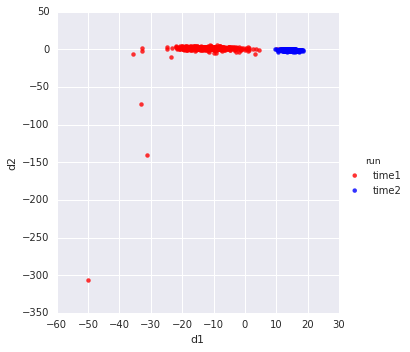

In [669]:
with open(join(topdir,'mESC_trans_time1_rep2','aggregated_counts/full_counts.txt')) as f:
    f.readline()
    data1 = np.asarray([map(float,x.strip().split('\t')[4:]) for x in f]).transpose()
with open(join(topdir,'mESC_trans_time2_rep2','aggregated_counts/full_counts.txt')) as f:
    f.readline()
    data2 = np.asarray([map(float,x.strip().split('\t')[4:]) for x in f]).transpose()

data = np.concatenate((data1/np.sum(data1),data2/np.sum(data2)))
print data.shape
data = mynormalizer2(data)

print '### PCA analasis ###'
Y = decomposition.PCA(n_components=2).fit(data).transform(data)
t_data = [[Y[idx][0],Y[idx][1],'time1'] if idx<len(data1) else [Y[idx][0],Y[idx][1],'time2']for idx in range(len(Y))]
d = pd.DataFrame(t_data,columns=['d1','d2','run'])
colors = {'time1':"r", 'time2':"b"}
sns.lmplot("d1", "d2", data=d, hue='run', fit_reg=False,palette=colors)
pylab.show()

##### PCA analysis on time point 1 （all genes)

In [223]:
### Check if the PC genes have enough counts
myexprt= expr_data['mESC_trans_time1_rep2']
data = myexprt['data_norm']
t_data = pd.DataFrame(np.sum(data,axis=0),columns=['sumCnt'])
t_data['gene'] = pd.Series(myexprt['genes'],index=t_data.index)
t_data = t_data.sort(['sumCnt'])
t_data['sumCntrank'] = pd.Series(range(len(t_data)),index=t_data.index)
important_genes = np.loadtxt('pc0_top50gene.txt',dtype='string')
pd.DataFrame([  [t_data[t_data['gene']==x]['sumCntrank'].iloc[0]/float(len(t_data)), \
                        t_data[t_data['gene']==x]['sumCnt'].iloc[0] \
                        ] for idx,x in enumerate(important_genes)],columns=['sumCntrank','sumCnt']).head()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


sumCntrank    sumCnt
0    0.992987  0.008979
1    0.996825  0.015198
2    0.991801  0.007659
3    0.988452  0.004424
4    0.999930  0.044735

Top contributors of the 1 PC
['Trpc2' 'Gm6803' 'Smt3h2-ps4' 'Gm6685' 'ENSMUSG00000099175'
 'ENSMUSG00000099164' 'Gm14777' 'RP23-24A9.7' 'ENSMUSG00000098681' 'Gm2056'
 'Gm14771' 'Gm6592' 'Gm14767' 'Olfr611' 'Olfr593' 'Gapdh-ps15' 'Gm14753'
 'Olfr628' 'Gm6565' 'Gm20563' 'Rnase2a' 'ENSMUSG00000098639'
 'ENSMUSG00000098633' 'Gm14749' 'Gm14765' 'Smlr1' 'Gm14783'
 'ENSMUSG00000098810' 'ENSMUSG00000099077' 'Gm6682' 'Gm6677' 'Gm6676'
 'Smok3b' 'ENSMUSG00000098930' 'Olfr598' 'Gm6659' 'ENSMUSG00000098892'
 'RP23-255N3.4' 'Olfr603' 'Gm6651' 'Gm6644' 'Gm6633' 'ENSMUSG00000098835'
 'RP23-252F4.5' 'Gm14784' 'Gm5619' '4930467E23Rik' '1700123I01Rik'
 '1700020N15Rik' '0610030E20Rik']
Saved to pc0_top50gene.txt
Top contributors of the 2 PC
['2200002D01Rik' 'Chchd10' 'Gjb5' 'Grina' 'Ly6a' 'Lrp2' 'P4ha1' 'Pros1'
 'Npl' 'Pcbd1' 'Clcn5' 'Fam134b' 'Lamb1' 'Krt8' 'Fhl1' 'Ctsh' 'Tax1bp3'
 'Serpina3m' 'Sparc' 'Klb' 'Htra1' 'Cited1' 'B2m' 'Sox7' 'Cryab' 'Lama1'
 'Gata4' 'Lgmn' 'P4ha2' 'Gjb3' 'Nostrin' 'Pdgfra' '

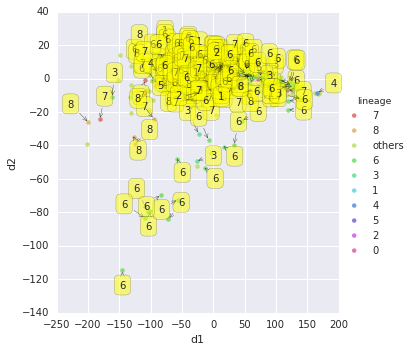

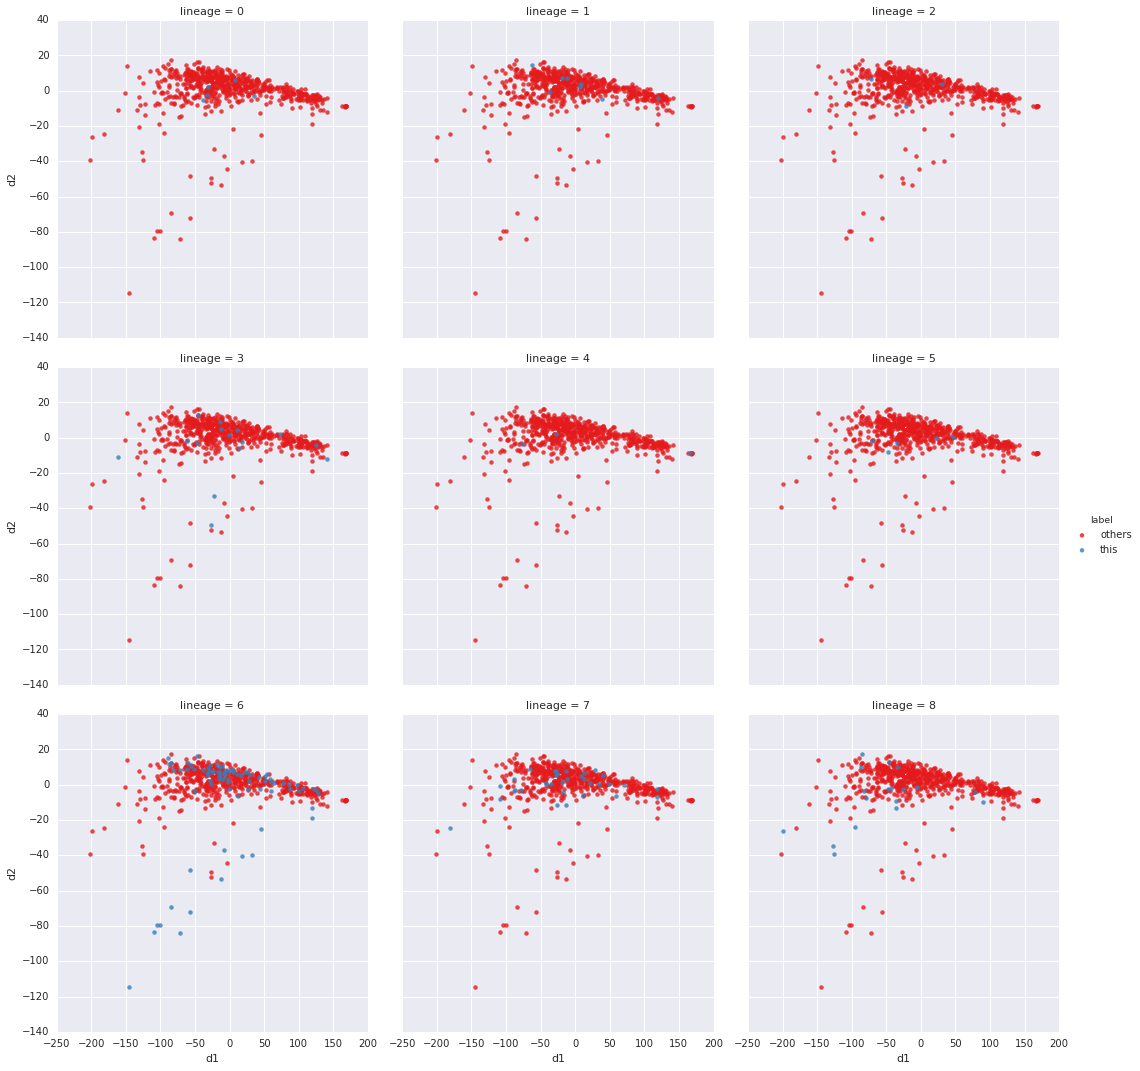

mean Silhouette Coefficient: -0.31429383258
P-value of Silhouette Coefficient: p= 0.328
### t-SNE analasis ###


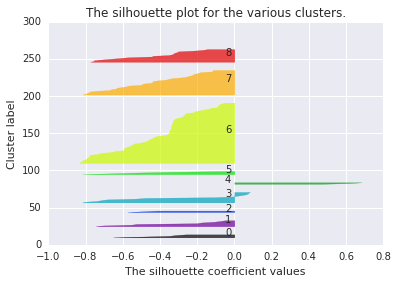

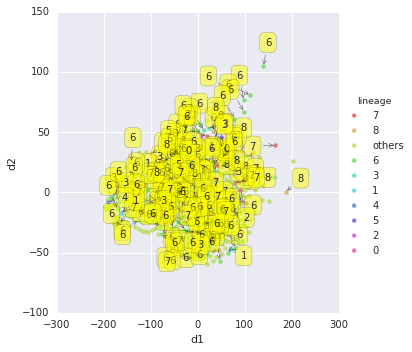

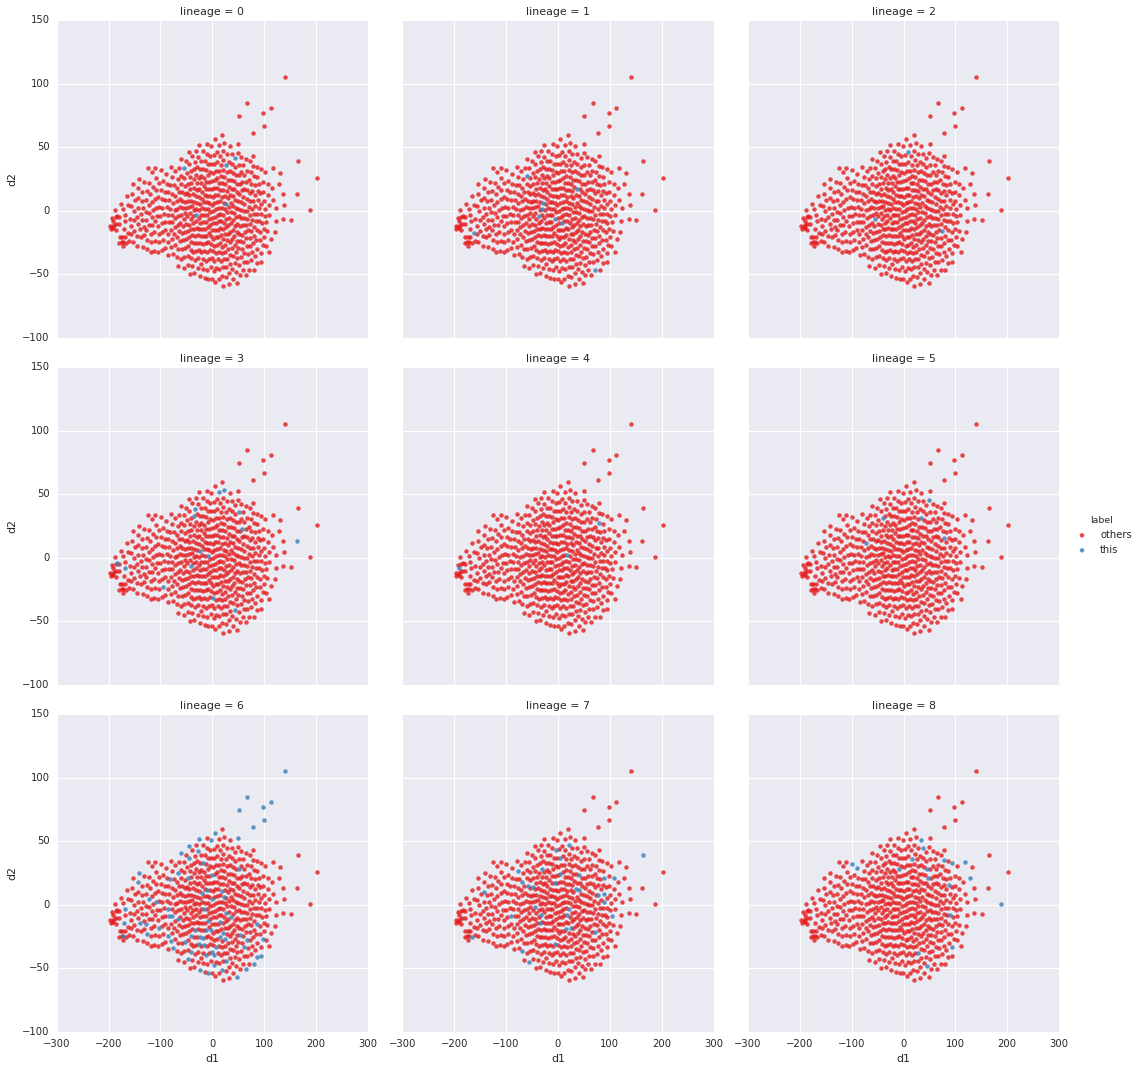

mean Silhouette Coefficient: -0.240534433634
P-value of Silhouette Coefficient: p= 0.217
### Isomap analasis ###


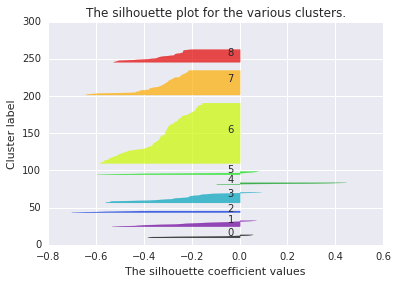

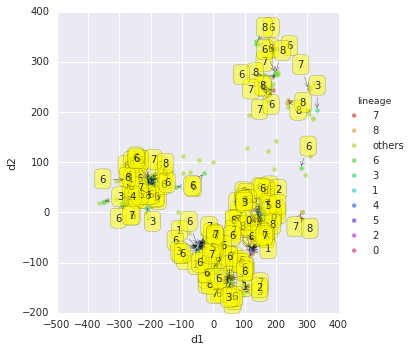

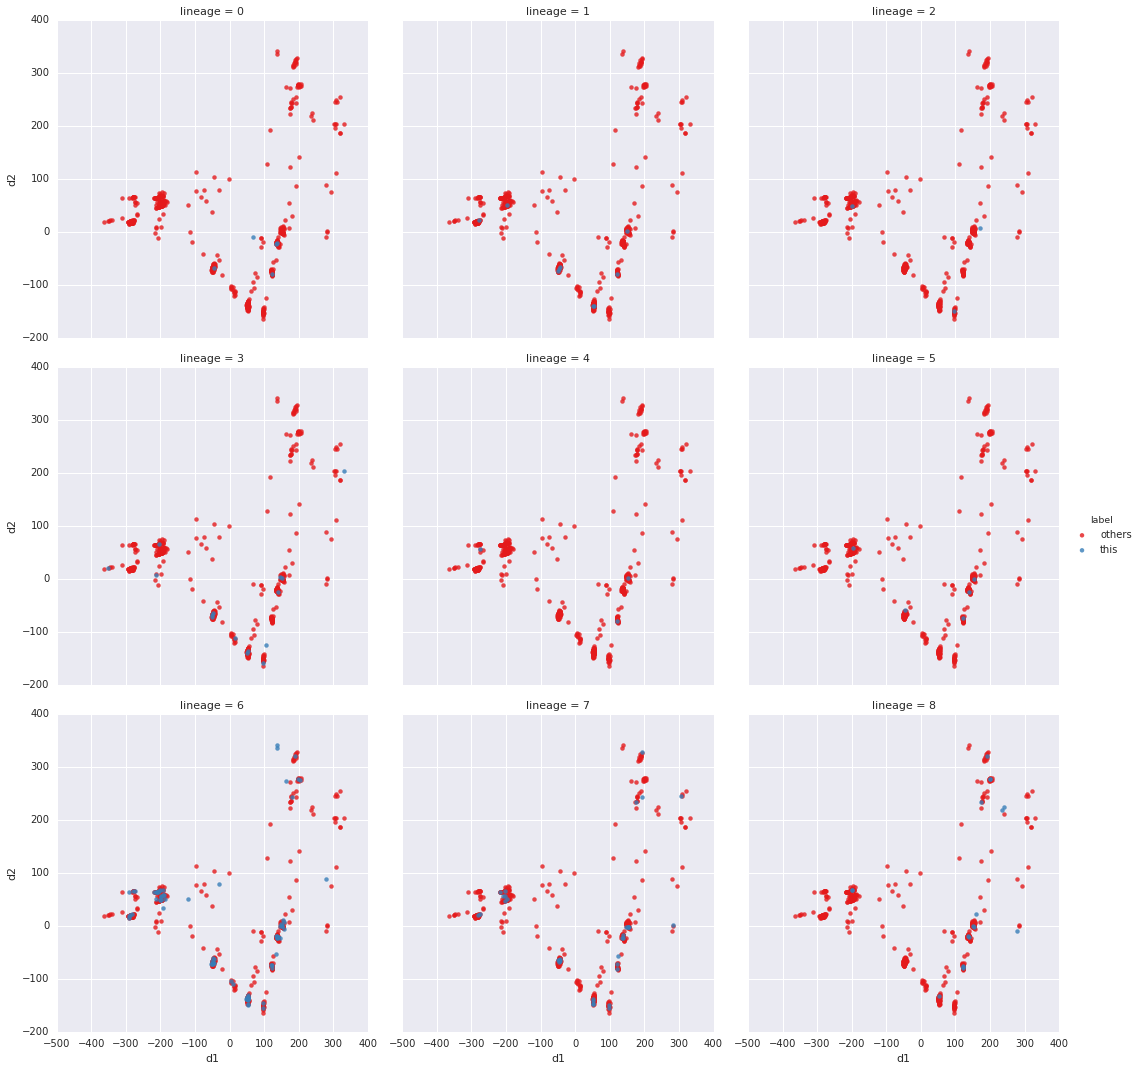

mean Silhouette Coefficient: -0.325653177424
P-value of Silhouette Coefficient: p= 0.462


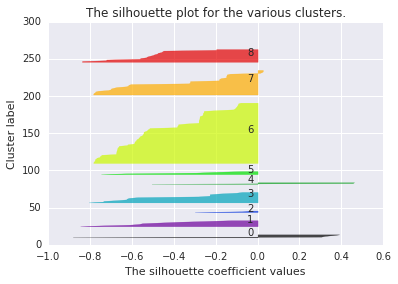

In [51]:
PCAanalysis(expr_data['mESC_trans_time1_rep2'])

##### PCA analysis on time point 1 （top genes)

Top contributors of the 1 PC
['Slc7a6' 'Zyx' 'Csrp1' 'Pmepa1' 'Reep5' 'Gpx3' 'Mfsd1' 'Ggta1' 'Commd3'
 'Cers2' 'Cald1' 'Wars' 'Me1' 'Atp6ap2' 'Jam3' 'Lpp' 'Pdlim7' 'Slc35f5'
 'Ifi30' 'Cnppd1' 'Amotl2' 'Plod2' 'Ckap4' 'S100a10' 'Ctsb' 'Arl4c'
 'Txndc12' 'F2r' 'Gm10775' 'Nefl' 'Dcaf12l1' 'Podxl' 'Gpc3' 'Hspg2' 'Apoe'
 'Sgpl1' 'Ddah1' 'Cstb' 'Soat1' 'Lamc1' 'Cst3' 'Lama1' 'Dab2' 'Tax1bp3'
 'Lamb1' 'Tpm1' 'Lrp2' 'Ctsl' 'Serpinh1' 'Sparc']
Saved to pc0_top50gene.txt
Top contributors of the 2 PC
['Lamb1' 'Arl4c' 'Msi1' 'Xbp1' 'Ifi30' 'Ggta1' 'Vcan' 'Glmp' 'Armcx2'
 'Gli3' 'Trp53i11' 'Id2' 'Dbn1' 'Limd2' 'Perp' 'Mfsd1' 'Kcnj3' 'Vrtn'
 'Cystm1' 'B4galt1' 'Serpinh1' 'Pdlim7' 'Bach1' 'Sat1' 'Gm10750' 'Abca13'
 'Sirt2' 'Gap43' 'Smim14' 'Fbxo15' 'Apbb1ip' 'Hes6' 'Tmem47' 'Sox3' 'Cd63'
 'Necap2' 'Pls3' 'Fndc3c1' 'Dpp4' 'Cd24a' 'Kif1a' 'Atp6v0a1' 'Cotl1' 'Tbx3'
 'Ctns' 'Elf3' 'Cndp2' 'Tfpi' 'Lama1' 'Dab2']
Saved to pc1_top50gene.txt
### PCA analasis ###


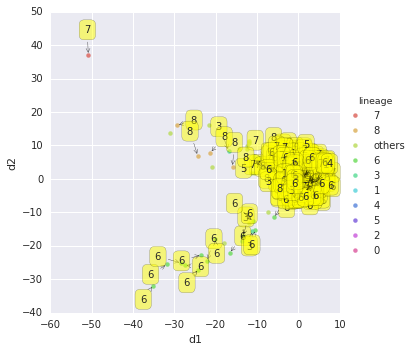

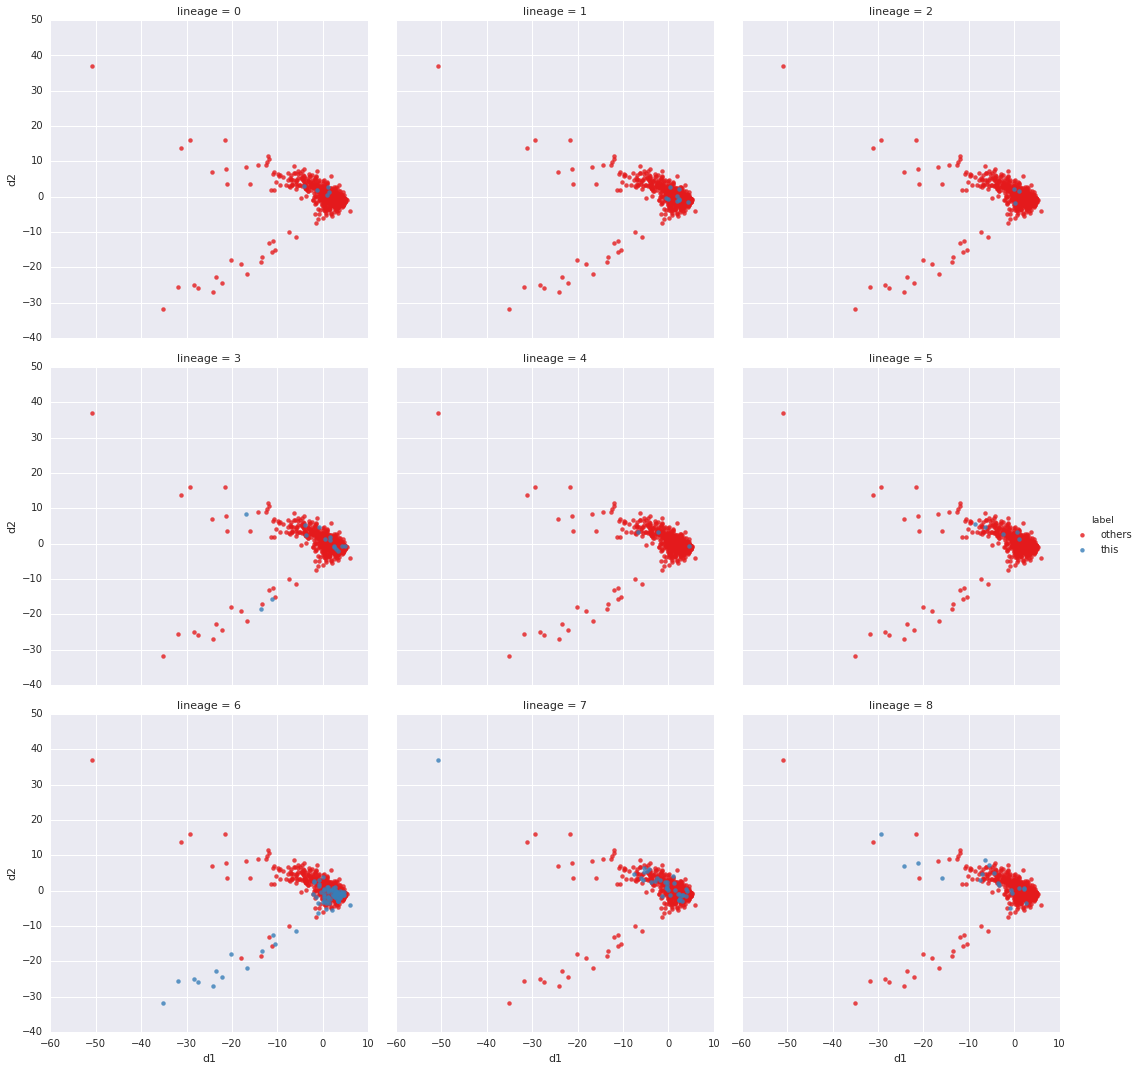

mean Silhouette Coefficient: -0.479191539603
P-value of Silhouette Coefficient: p= 0.616
### t-SNE analasis ###


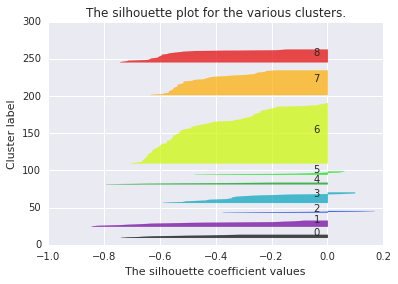

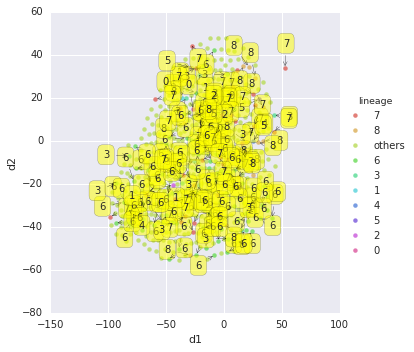

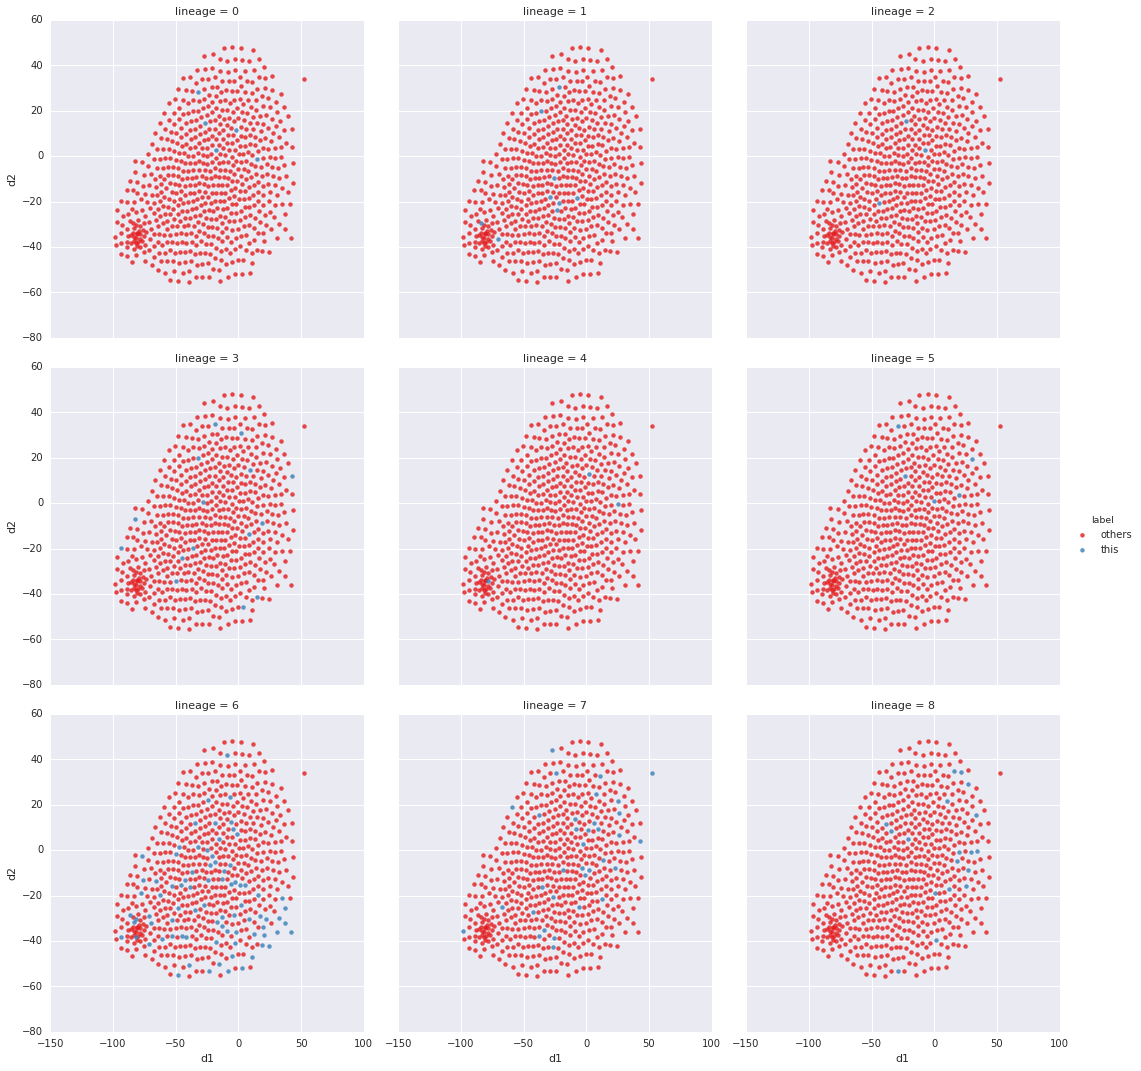

mean Silhouette Coefficient: -0.245714421699
P-value of Silhouette Coefficient: p= 0.383
### Isomap analasis ###


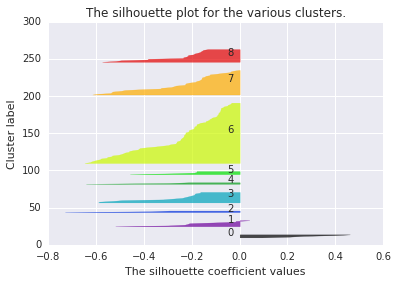

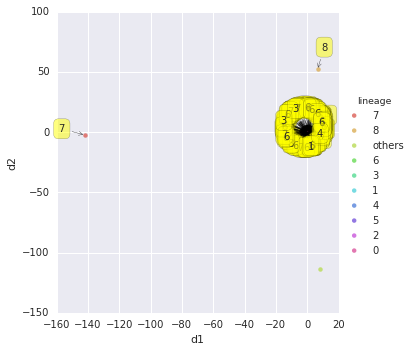

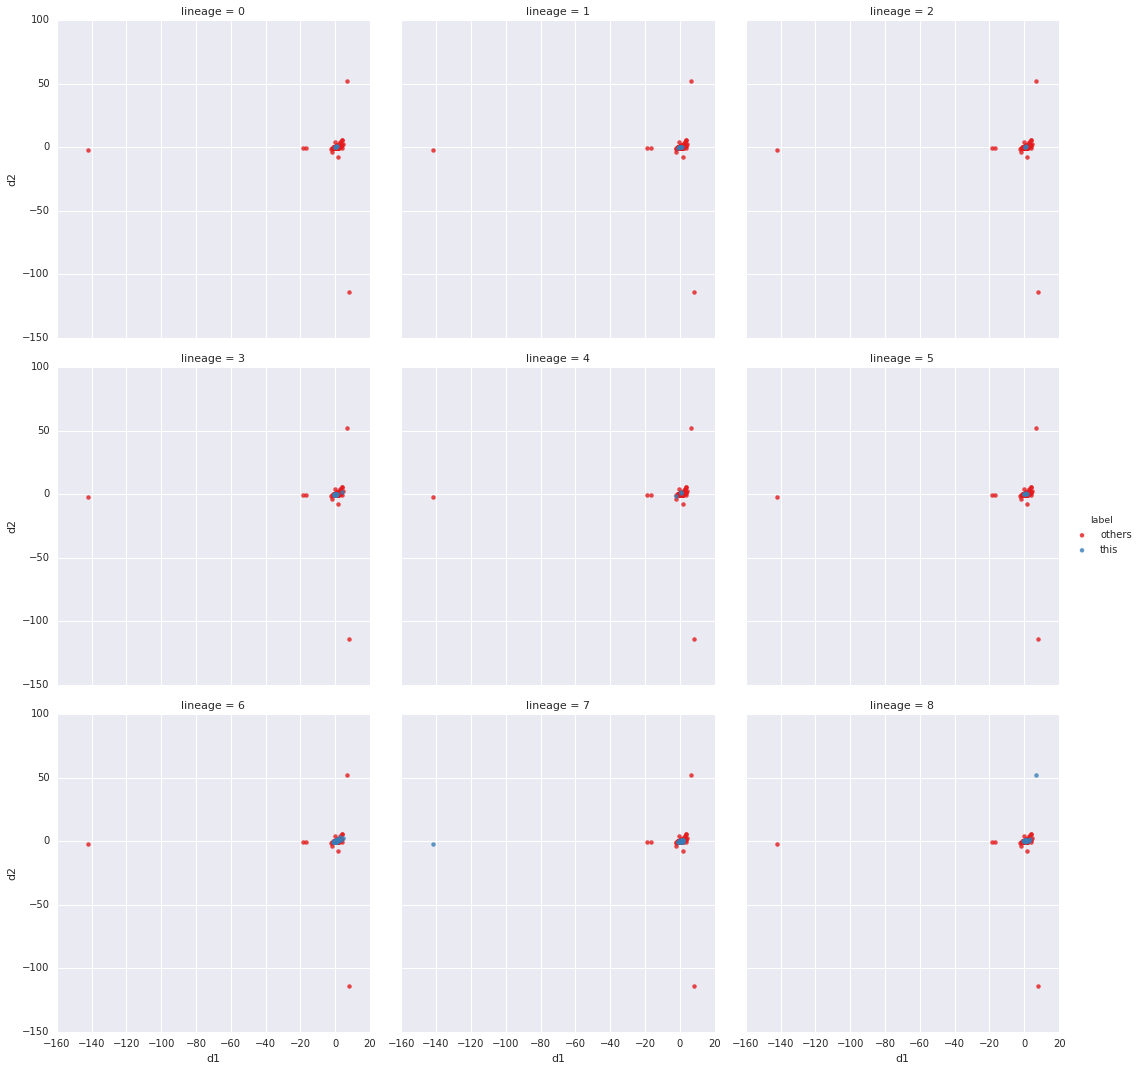

mean Silhouette Coefficient: -0.441412908294
P-value of Silhouette Coefficient: p= 0.226


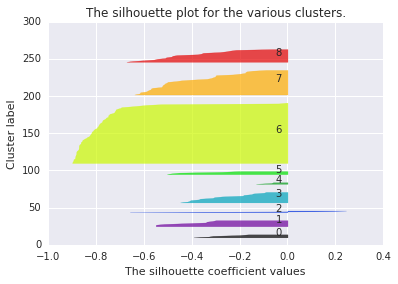

In [50]:
PCAanalysis(expr_data['mESC_trans_time1_rep2_top'])

##### PCA analysis on time2 (all genes)

Top contributors of the 1 PC
['1700057G04Rik' '1700042G07Rik' '4933402N22Rik' '4933405L10Rik'
 '1700019A02Rik' '4921513D11Rik' '4933406M09Rik' '4930415O20Rik'
 '1700011M02Rik' '4930444G20Rik' '1700049L16Rik' '1700019N19Rik'
 '1600014K23Rik' '4930432M17Rik' '4933402N03Rik' '4930579G24Rik'
 '1700001L19Rik' '4930415F15Rik' '1700029F12Rik' '4930402K13Rik'
 '1700020N01Rik' '1700028J19Rik' '1700034I23Rik' '4930505A04Rik'
 '2310034C09Rik' '4930474N05Rik' '4930480E11Rik' '1700084J12Rik'
 '1810022K09Rik' '4930595M18Rik' '1700016H13Rik' '4930407I10Rik'
 '4933402J07Rik' '2310057N15Rik' '4922502D21Rik' '1700026L06Rik'
 '1700001J03Rik' '1600014C23Rik' '4931414P19Rik' '1700011L22Rik'
 '1700007B14Rik' '1700001J11Rik' '1700012A03Rik' '1700011I03Rik'
 '1700012B09Rik' '1500009C09Rik' '1600029O15Rik' '1600002K03Rik'
 '1110032F04Rik' '1110008P14Rik']
Saved to pc0_top50gene.txt
Top contributors of the 2 PC
['Olfr902' 'Akr1c6' 'Slc6a8' 'Zbtb12' 'Klhl15' 'Taf13' 'Acsm2' 'Golph3l'
 'Acsf2' 'Itga2b' 'Pou5f2' '

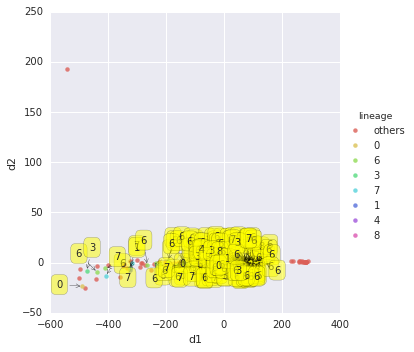

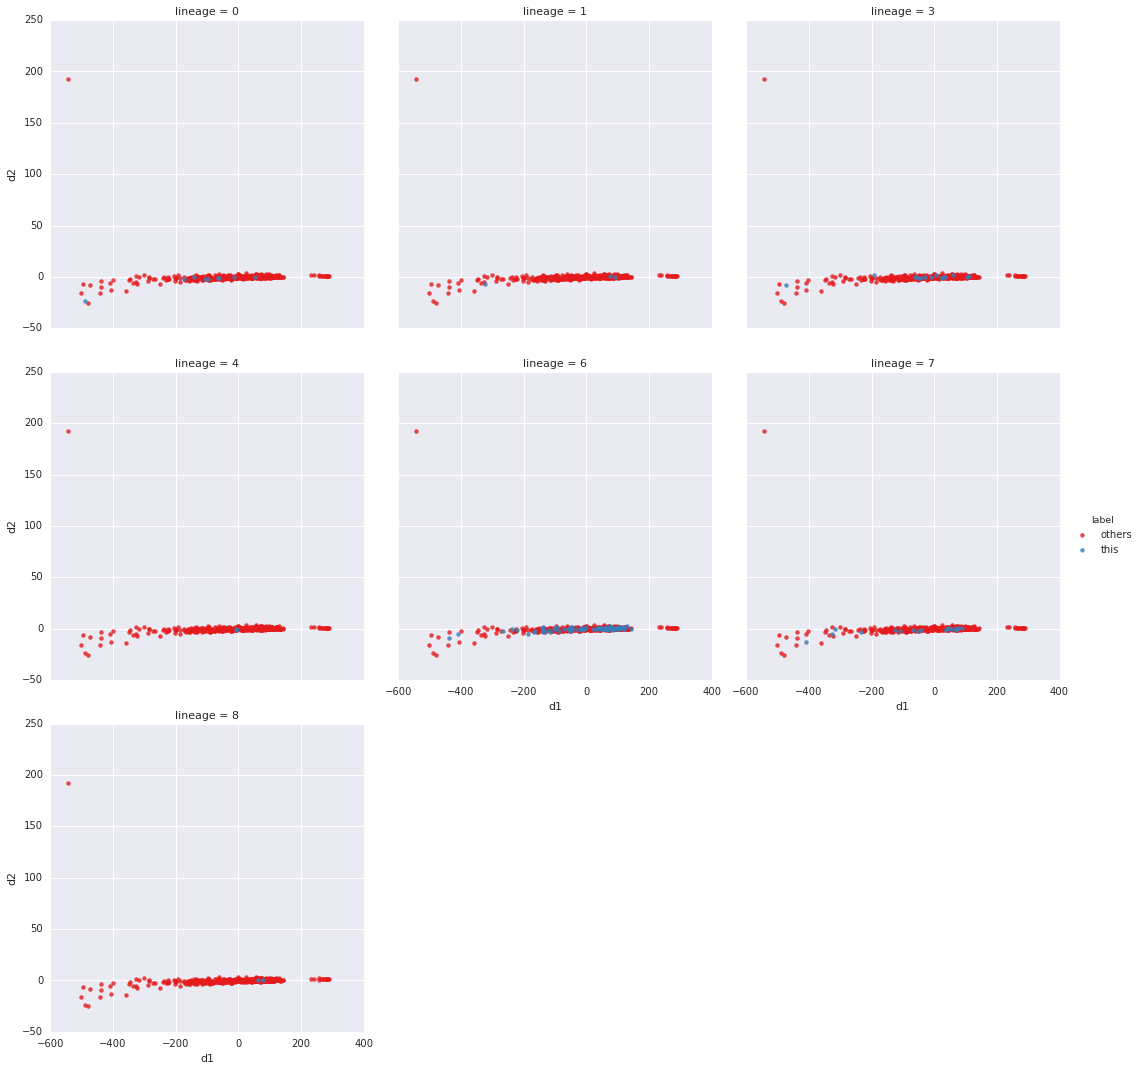

mean Silhouette Coefficient: -0.576835913442
P-value of Silhouette Coefficient: p= 0.942
### t-SNE analasis ###


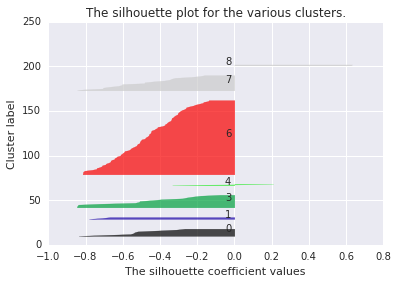

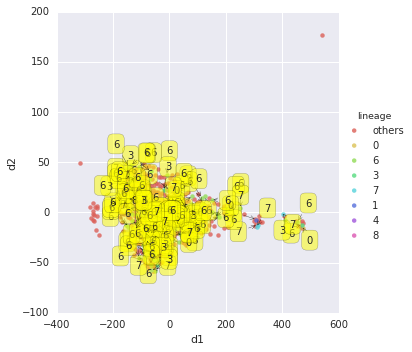

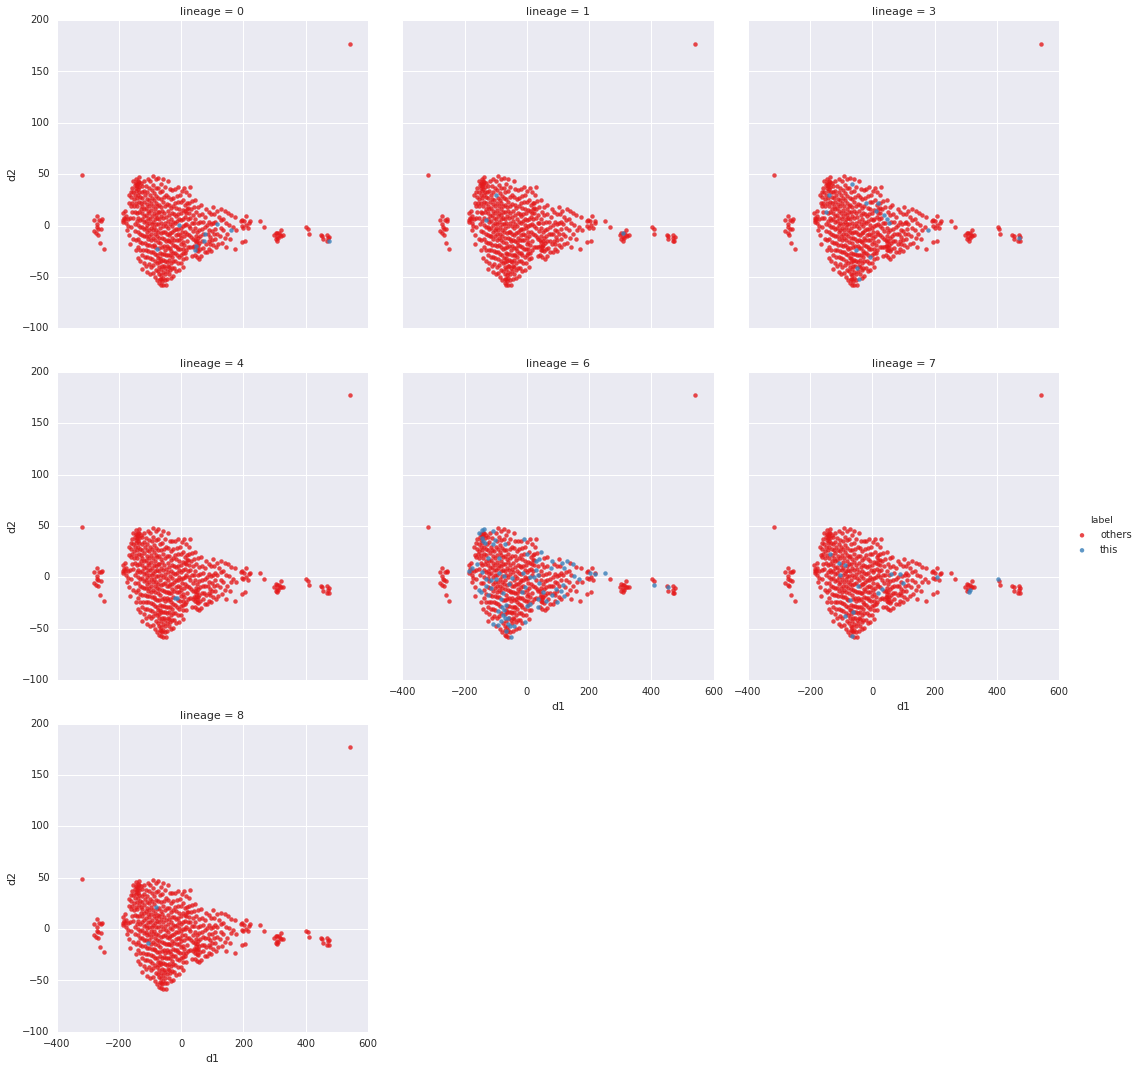

mean Silhouette Coefficient: -0.496035746153
P-value of Silhouette Coefficient: p= 0.921
### Isomap analasis ###


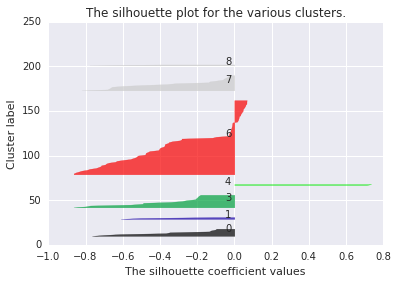

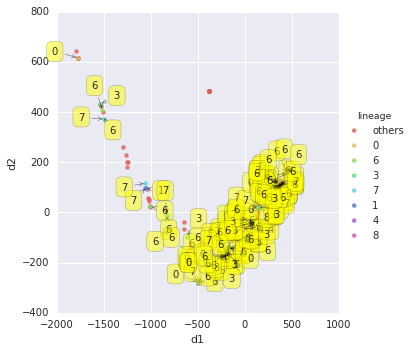

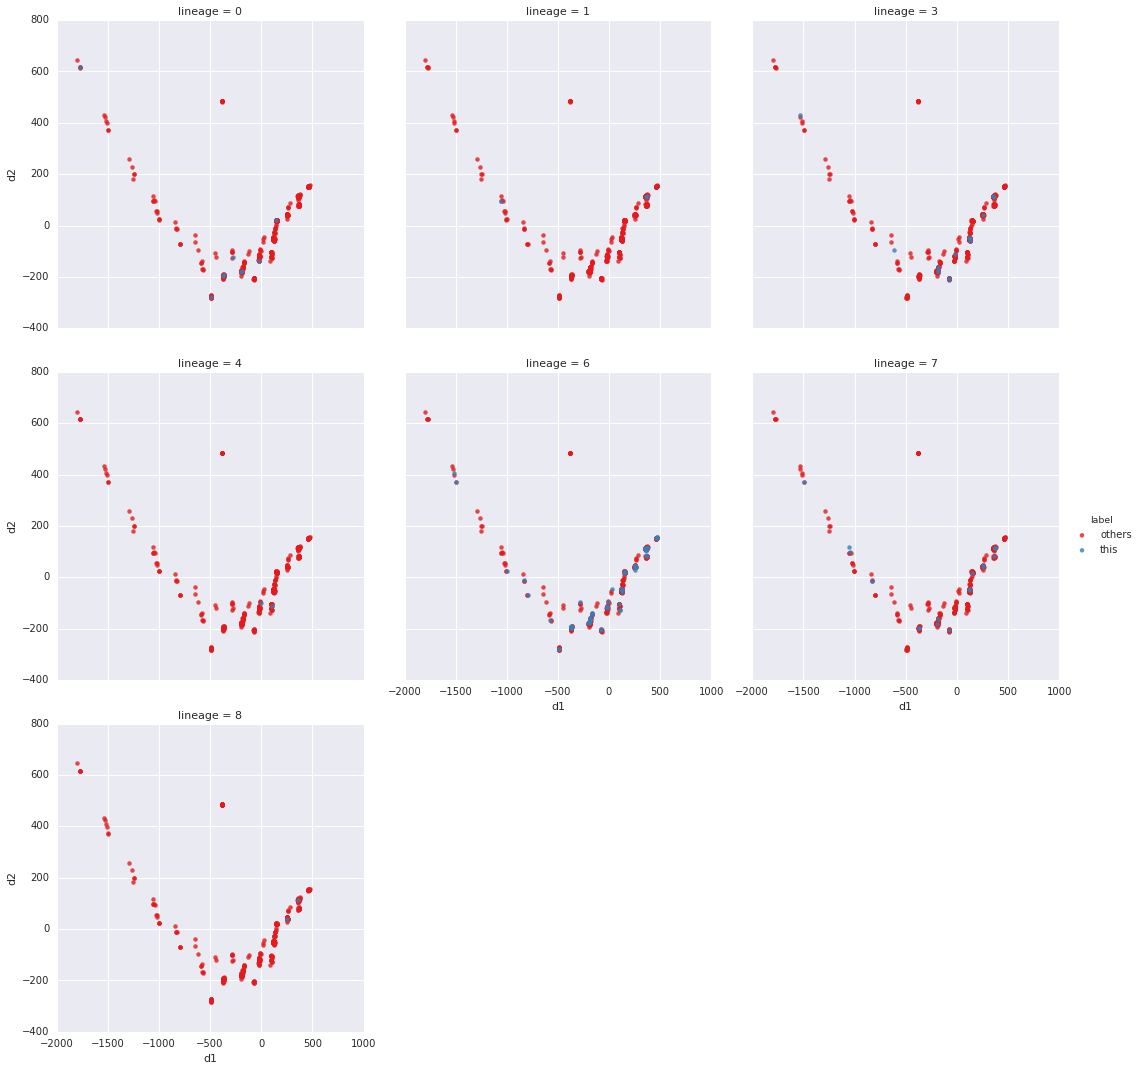

mean Silhouette Coefficient: -0.546274435189
P-value of Silhouette Coefficient: p= 0.887


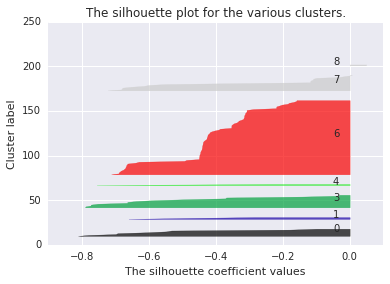

In [56]:
PCAanalysis(expr_data['mESC_trans_time2_rep2'])

##### PCA analysis on time point 2 （top genes)

Top contributors of the 1 PC
['Eif4g1' 'Ngfrap1' 'Sall4' 'Ywhab' 'Srm' 'Mapk1' 'Nasp' 'Sox2' 'Tuba1a'
 'Lman2' 'Dynll1' 'Stmn2' 'Ap2m1' 'Fhl1' 'Dnajc9' 'Pdap1' 'Capns1' 'Ryk'
 'P4hb' 'Gap43' 'Src' 'Myl12a' 'Rbms1' 'Ptms' 'Cd59b' 'Map1b' 'Msn' 'Flna'
 'Zwint' 'Car2' 'Ssbp3' 'Dppa5a' 'Apela' 'Anxa3' 'Sptbn1' 'Csrp1' 'Myadm'
 'Basp1' 'Chd4' 'Itgb1' 'Thbs1' 'S100a6' 'Scd2' 'Hspb1' 'Ahnak' 'Tmsb4x'
 'Igf2' 'Actn1' 'Tagln' 'Krt8']
Saved to pc0_top50gene.txt
Top contributors of the 2 PC
['Ap2a2' 'Eif4ebp1' 'Eif4g2' 'Cep170b' 'Stip1' 'Coro1c' 'Hint1' 'Mtap'
 'Ctnna1' 'Sec31a' 'Srsf11' 'Atp5g3' 'Gbp2' 'Eif4e' 'Nasp' 'Nars' 'Cadm1'
 'Hnrnpa0' 'Rab14' 'Txn-ps1' 'Cdk1' 'Fus' 'Fscn1' 'Gab1' 'Gap43' 'Cks1b'
 'Manf' 'Tuba1a' 'Oaz1' 'Kcmf1' 'Mest' 'Fn1' 'Nras' 'Eprs' 'Pim1' 'Kif23'
 'Max' 'Eif1' 'Top2a' 'Lrrfip1' 'Trim28' 'Tmsb10' 'Anapc11' 'mt-Nd4l'
 'Vdac1' 'Phf5a' 'Ube2d2a' 'Idi1' 'Chmp4b' 'Mtch1']
Saved to pc1_top50gene.txt
### PCA analasis ###


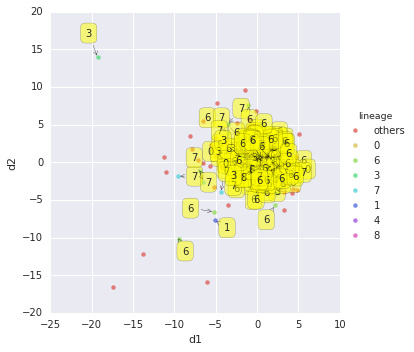

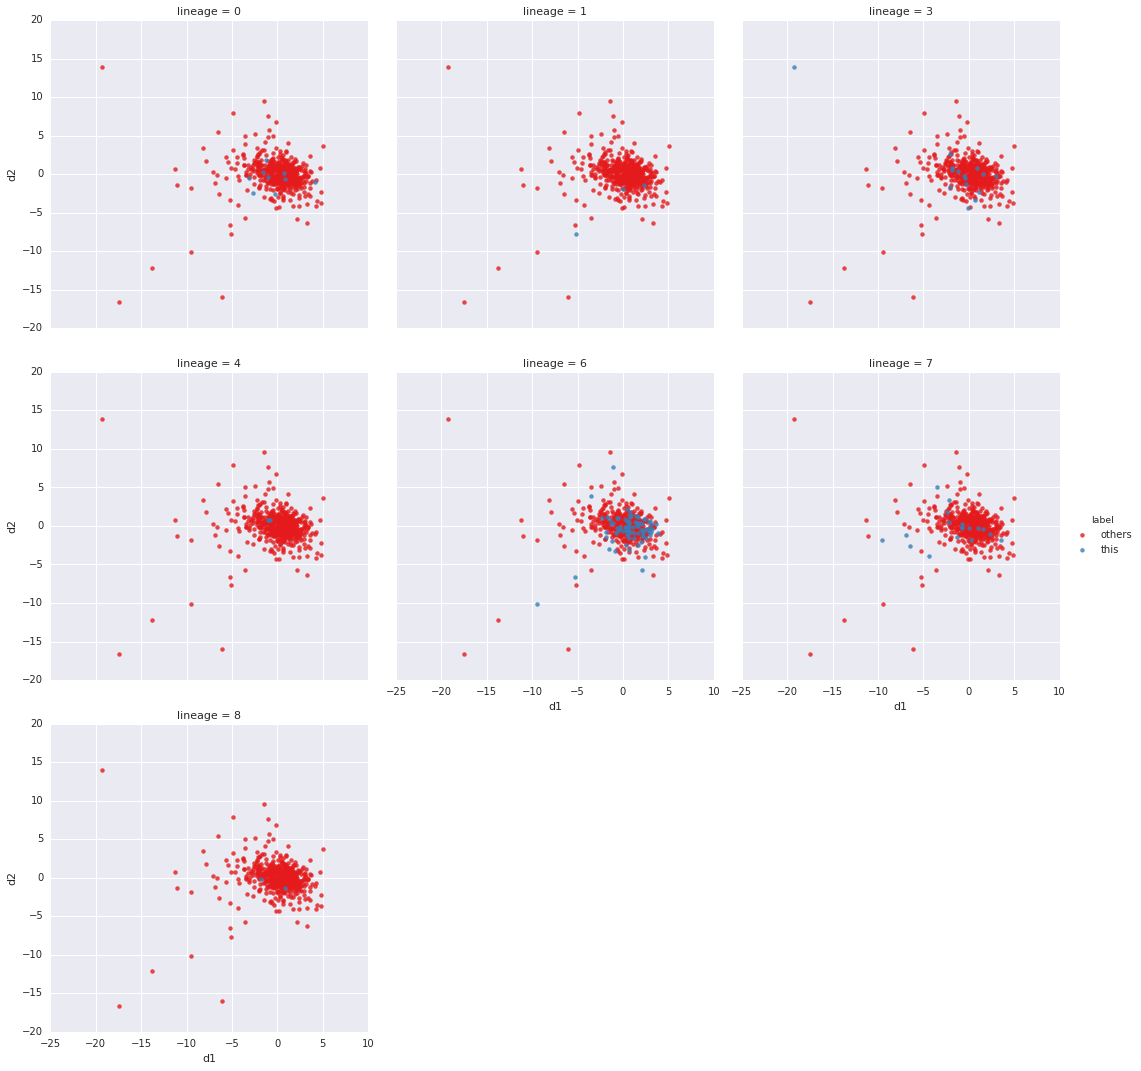

mean Silhouette Coefficient: -0.272957499384
P-value of Silhouette Coefficient: p= 0.114
### t-SNE analasis ###


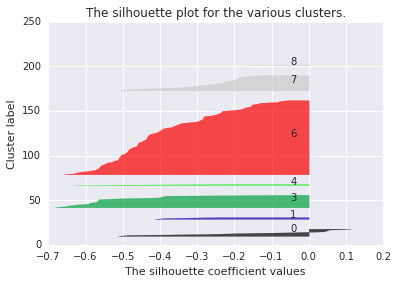

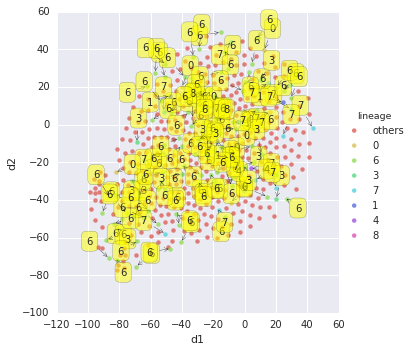

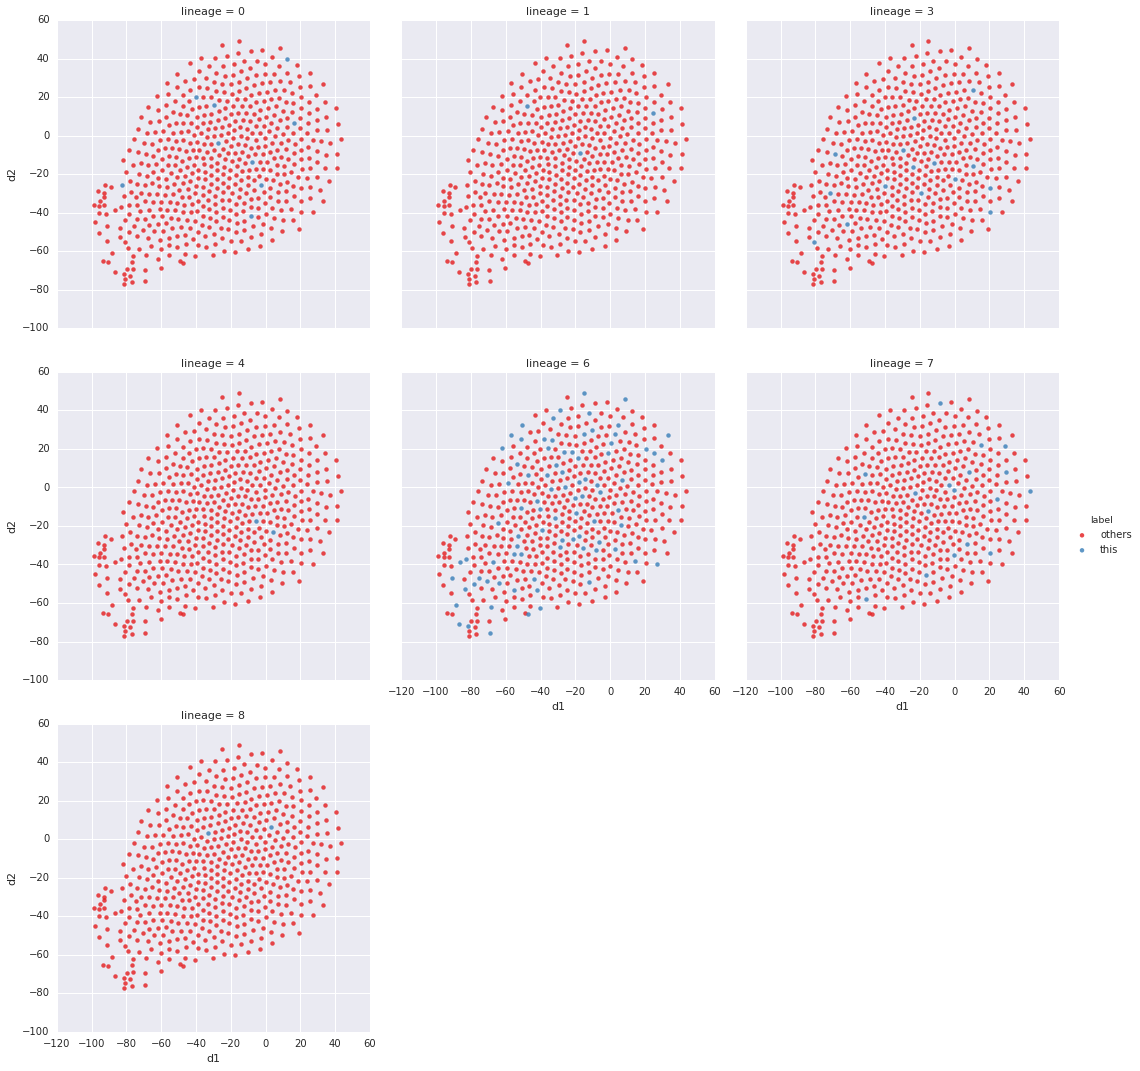

mean Silhouette Coefficient: -0.341370988706
P-value of Silhouette Coefficient: p= 0.793
### Isomap analasis ###


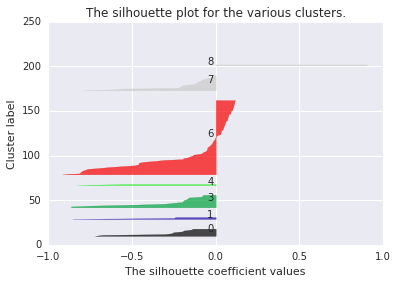

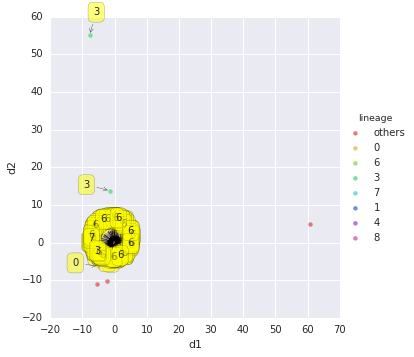

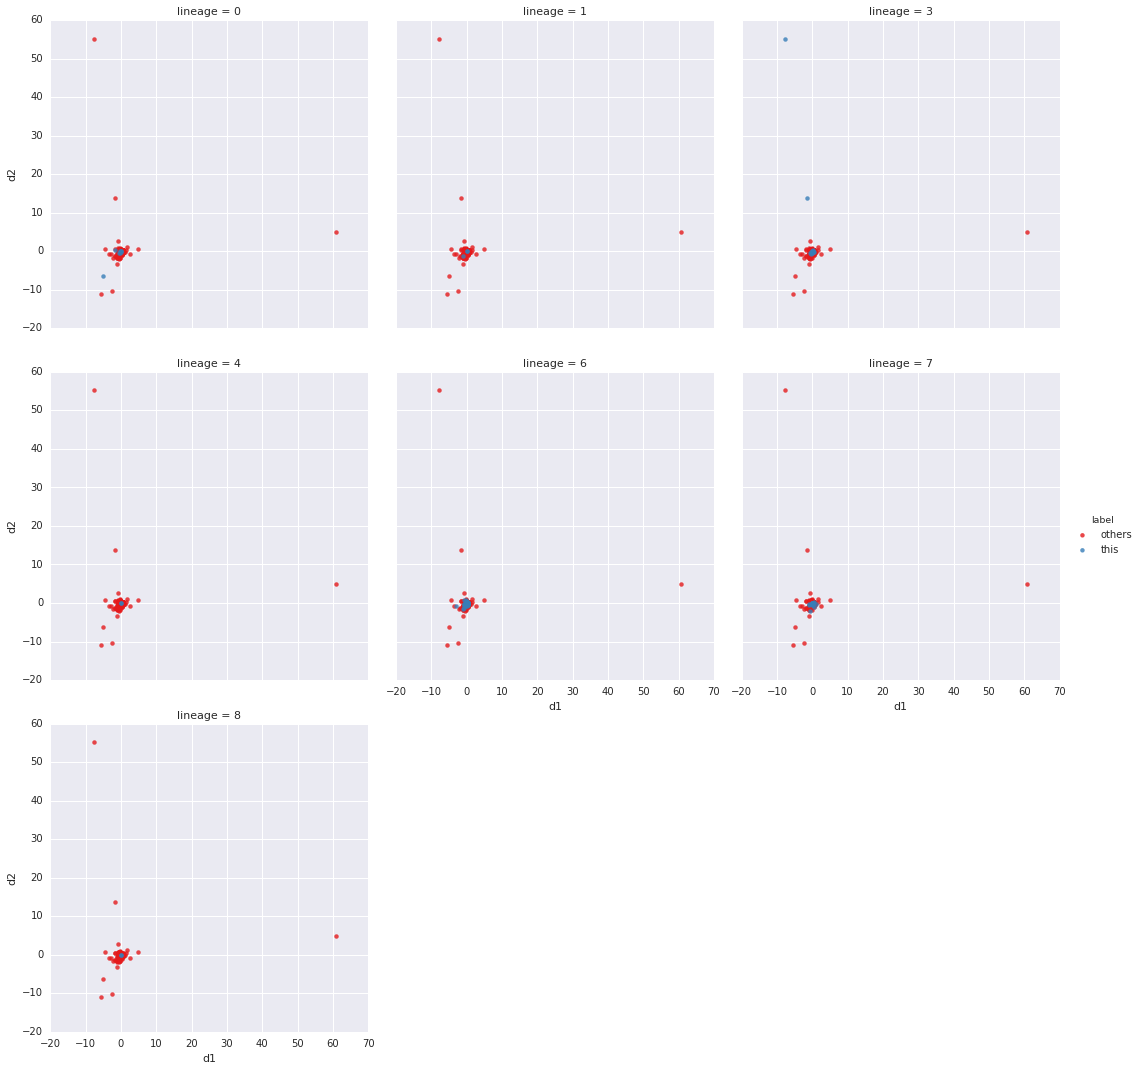

mean Silhouette Coefficient: -0.508896673604
P-value of Silhouette Coefficient: p= 0.153


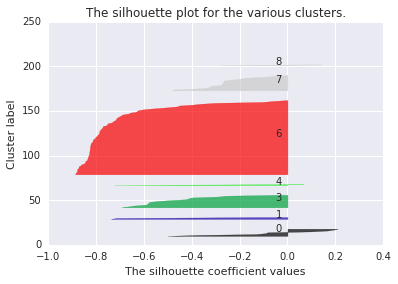

In [57]:
PCAanalysis(expr_data['mESC_trans_time2_rep2_top'])

#### Treat each allele differently

In [16]:
lineage_assignment = pd.read_csv(join(topdir,'mESC_fth1_timeboth_rep2/post_split/final_lineage_assignment_allelic.csv'))

for expt in ['mESC_fth1_time1_rep2','mESC_fth1_time2_rep2']:
    cellbc2lineage = dict()
    with open(join(topdir,expt,'pre_split/good_barcodes_with_names.pickle'),'rb') as f:
        cellbc2name = cPickle.load(f)
    name2lineagebc = pd.read_csv(join(topdir,expt,'post_split',\
                'cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2.familyanalysis-cellcentric.thres10.csv'))
    for idx,key in enumerate(cellbc2name.keys()) :
        t_row = name2lineagebc[name2lineagebc['cell']==cellbc2name[key]]['barcodes']
        if len(t_row>0):
            t_barcodes = ','.join(np.sort(t_row.iloc[0].split(',')))
            t_lineage = lineage_assignment[lineage_assignment['Barcodes']==t_barcodes]['Lineage']
            if len(t_lineage) > 0:
                cellbc2lineage[key] = t_lineage.iloc[0]
                with open(join(topdir,expt,'post_split','cellbc2lineage_allelic.pkl'),'wb') as f:
                    cPickle.dump(cellbc2lineage,f)

In [17]:
### Load expression data
expr_data_allelic = dict()
summary = []
for t_expt_trans in ['mESC_trans_time1_rep2','mESC_trans_time2_rep2']:
    t_expt_fth1 = t_expt_trans.replace('trans','fth1')
    with open(join(topdir,t_expt_fth1,'post_split','cellbc2lineage_allelic.pkl'),'rb') as f:
        cellbc2lineage = cPickle.load(f)
    with open(join(topdir,t_expt_trans,'pre_split/good_barcodes_with_names.pickle'),'rb') as f:
        cellbc2name = cPickle.load(f)

    t_mapper = dict()
    t_table = []
    for idx,key in enumerate(cellbc2name.keys()):
        t_lineage = cellbc2lineage[key] if key in cellbc2lineage.keys() else 'NA'
        t_mapper[cellbc2name[key]] = t_lineage
        t_table.append([cellbc2name[key],t_lineage])
    t_value_cnt = pd.DataFrame(t_table,columns=['name','lineage'])['lineage'].value_counts()
    t_datafiles = [join(topdir,t_expt_trans,'aggregated_counts/full_counts.txt'),\
                        join(topdir,t_expt_trans,'aggregated_counts/ambig_counts.txt')]
    expr_data_allelic[t_expt_trans] = loadexpr(t_datafiles,t_mapper)
    summary += [[t_value_cnt.index[idx],x,t_expt_trans] for idx,x in enumerate(t_value_cnt)]

pd.pivot_table(pd.DataFrame(summary,columns=['Lineage','cell cnt','Expt']),\
               values='cell cnt',index='Lineage',columns='Expt')

shape of expression matrix (635, 28662)
shape of expression matrix (545, 28662)


Expt     mESC_trans_time1_rep2  mESC_trans_time2_rep2
Lineage                                              
0                            5                      9
1                            9                      3
2                            3                    NaN
3                           12                     12
4                            3                      2
5                          NaN                      1
6                            2                    NaN
7                          NaN                      2
8                            1                    NaN
9                            2                    NaN
10                           2                    NaN
11                           1                    NaN
12                          51                     72
13                          34                     18
14                          18                      9
15                          18                      2
16                          13                      3
NA                         461                    412

In [22]:
### Top data are the same for the non-allelic case except for lineage info
for t_expt_trans in ['mESC_trans_time1_rep2','mESC_trans_time2_rep2']:
    expr_data_allelic[t_expt_trans]['data_norm'] = np.copy(expr_data[t_expt_trans]['data_norm'] )
    
    expr_data_allelic[t_expt_trans+'_top'] = dict()
    expr_data_allelic[t_expt_trans+'_top']['data_norm'] = np.copy(expr_data[t_expt_trans+'_top']['data_norm'])
    expr_data_allelic[t_expt_trans+'_top']['data'] = np.copy(expr_data[t_expt_trans+'_top']['data'])
    expr_data_allelic[t_expt_trans+'_top']['lineageinfo'] = np.copy(expr_data_allelic[t_expt_trans]['lineageinfo'])
    #expr_data_allelic[t_expt_trans+'_top']['lineageinfo'] = np.copy(expr_data[t_expt_trans+'_top']['lineageinfo'])
    expr_data_allelic[t_expt_trans+'_top']['genes'] = np.copy(expr_data[t_expt_trans+'_top']['genes'])

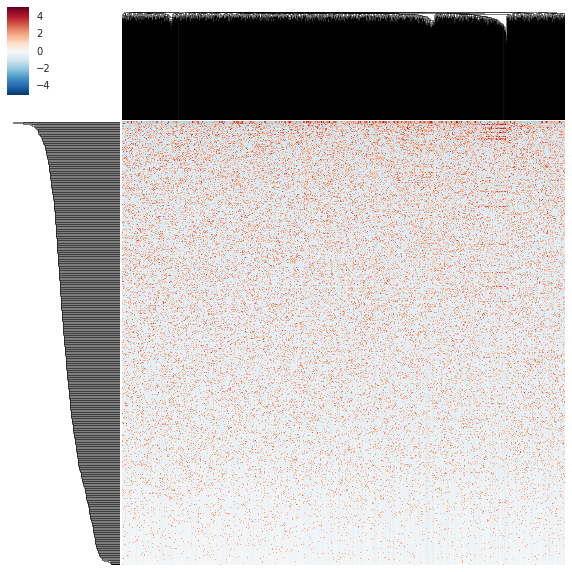

In [58]:
sns.clustermap(expr_data['mESC_trans_time1_rep2_top']['data_norm'],xticklabels=False,yticklabels=False,\
               row_cluster=True,col_cluster=True)

##### PCA analysis on time point 1 （all genes,allelic)

Top contributors of the 1 PC
['Trpc2' 'Gm6803' 'Smt3h2-ps4' 'Gm6685' 'ENSMUSG00000099175'
 'ENSMUSG00000099164' 'Gm14777' 'RP23-24A9.7' 'ENSMUSG00000098681' 'Gm2056'
 'Gm14771' 'Gm6592' 'Gm14767' 'Olfr611' 'Olfr593' 'Gapdh-ps15' 'Gm14753'
 'Olfr628' 'Gm6565' 'Gm20563' 'Rnase2a' 'ENSMUSG00000098639'
 'ENSMUSG00000098633' 'Gm14749' 'Gm14765' 'Smlr1' 'Gm14783'
 'ENSMUSG00000098810' 'ENSMUSG00000099077' 'Gm6682' 'Gm6677' 'Gm6676'
 'Smok3b' 'ENSMUSG00000098930' 'Olfr598' 'Gm6659' 'ENSMUSG00000098892'
 'RP23-255N3.4' 'Olfr603' 'Gm6651' 'Gm6644' 'Gm6633' 'ENSMUSG00000098835'
 'RP23-252F4.5' 'Gm14784' 'Gm5619' '4930467E23Rik' '1700123I01Rik'
 '1700020N15Rik' '0610030E20Rik']
Saved to pc0_top50gene.txt
Top contributors of the 2 PC
['2200002D01Rik' 'Chchd10' 'Gjb5' 'Grina' 'Ly6a' 'Lrp2' 'P4ha1' 'Pros1'
 'Npl' 'Pcbd1' 'Clcn5' 'Fam134b' 'Lamb1' 'Krt8' 'Fhl1' 'Ctsh' 'Tax1bp3'
 'Serpina3m' 'Sparc' 'Klb' 'Htra1' 'Cited1' 'B2m' 'Sox7' 'Cryab' 'Lama1'
 'Gata4' 'Lgmn' 'P4ha2' 'Gjb3' 'Nostrin' 'Pdgfra' '

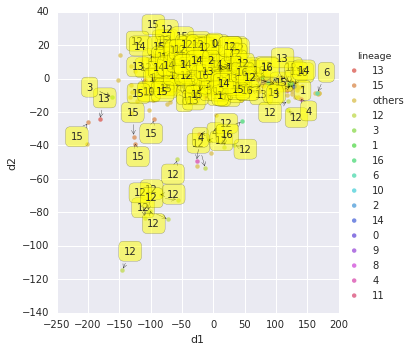

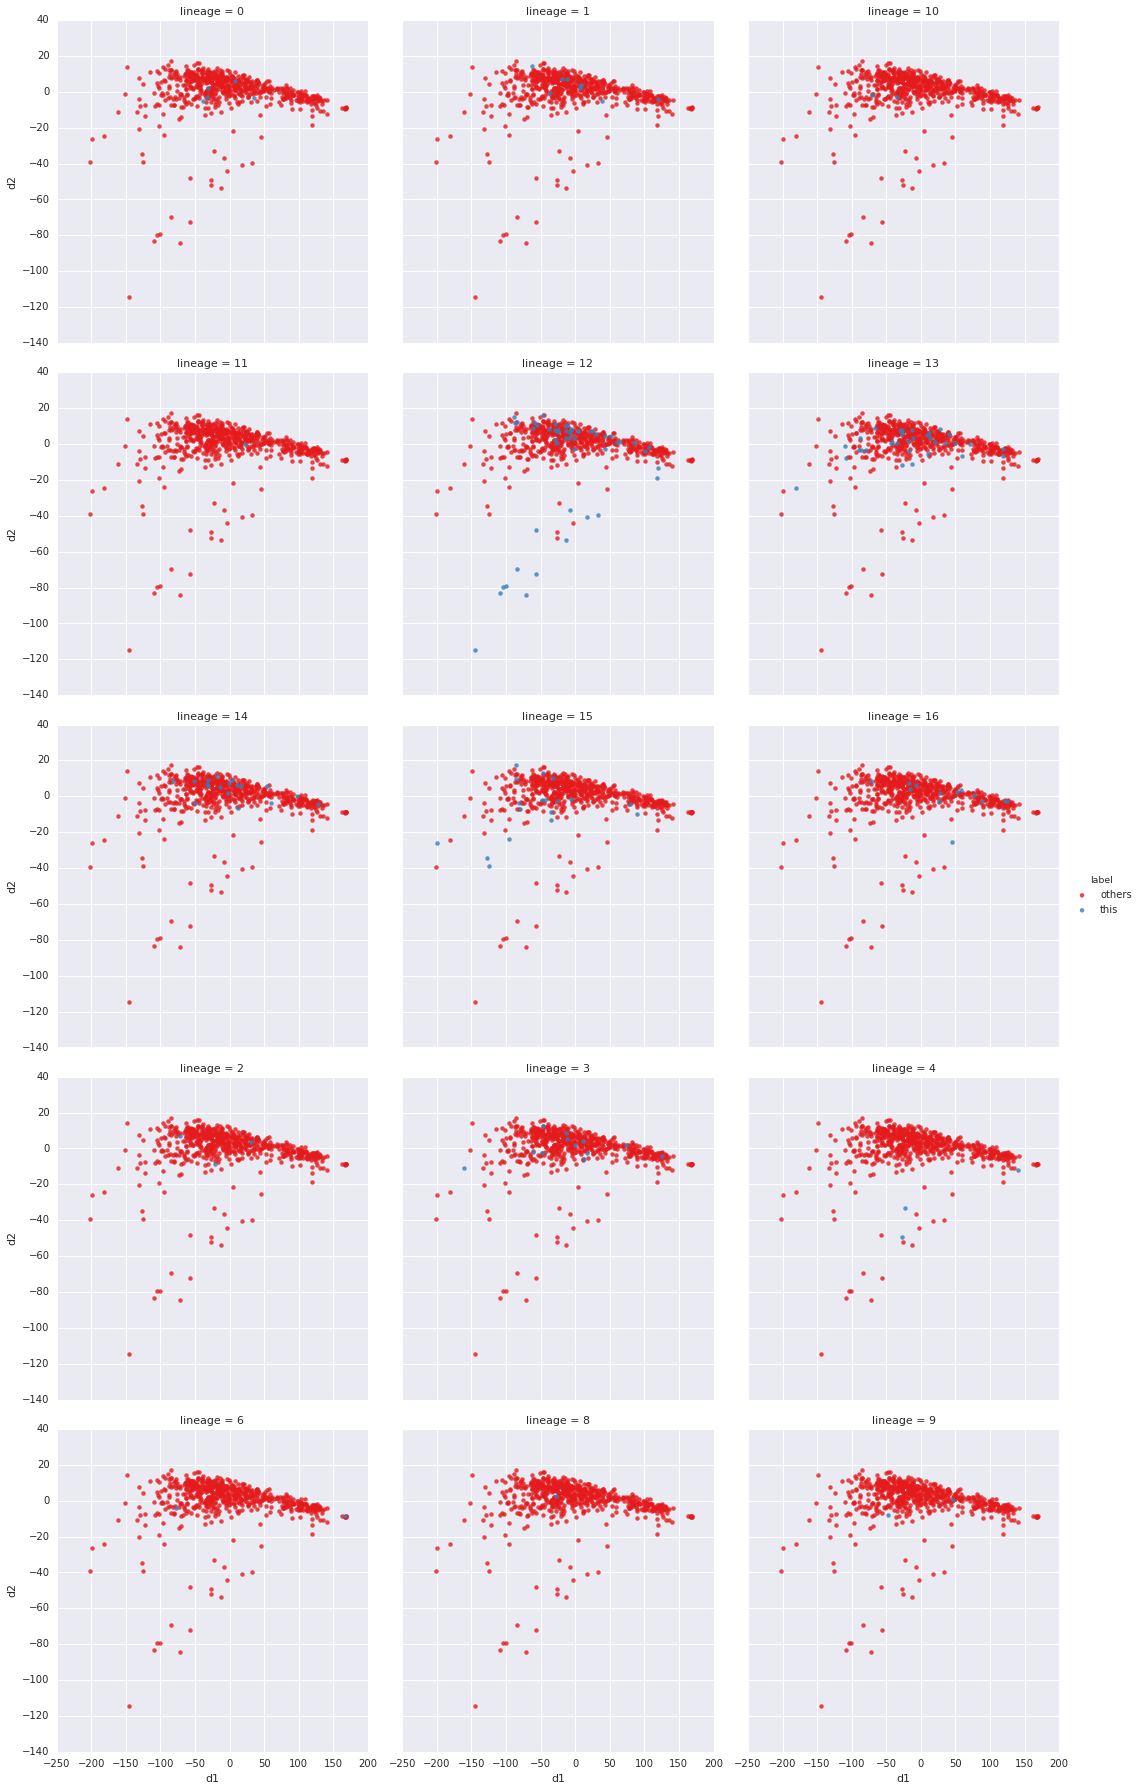

mean Silhouette Coefficient: -0.592586060552
P-value of Silhouette Coefficient: p= 0.754
### t-SNE analasis ###


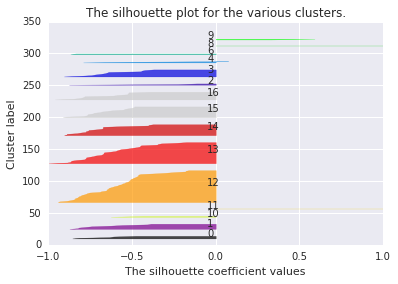

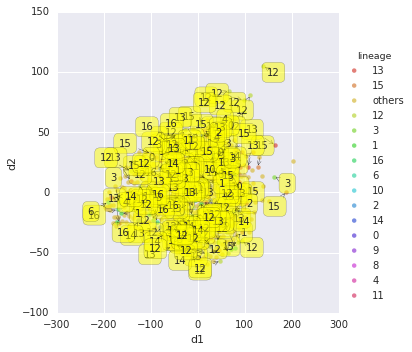

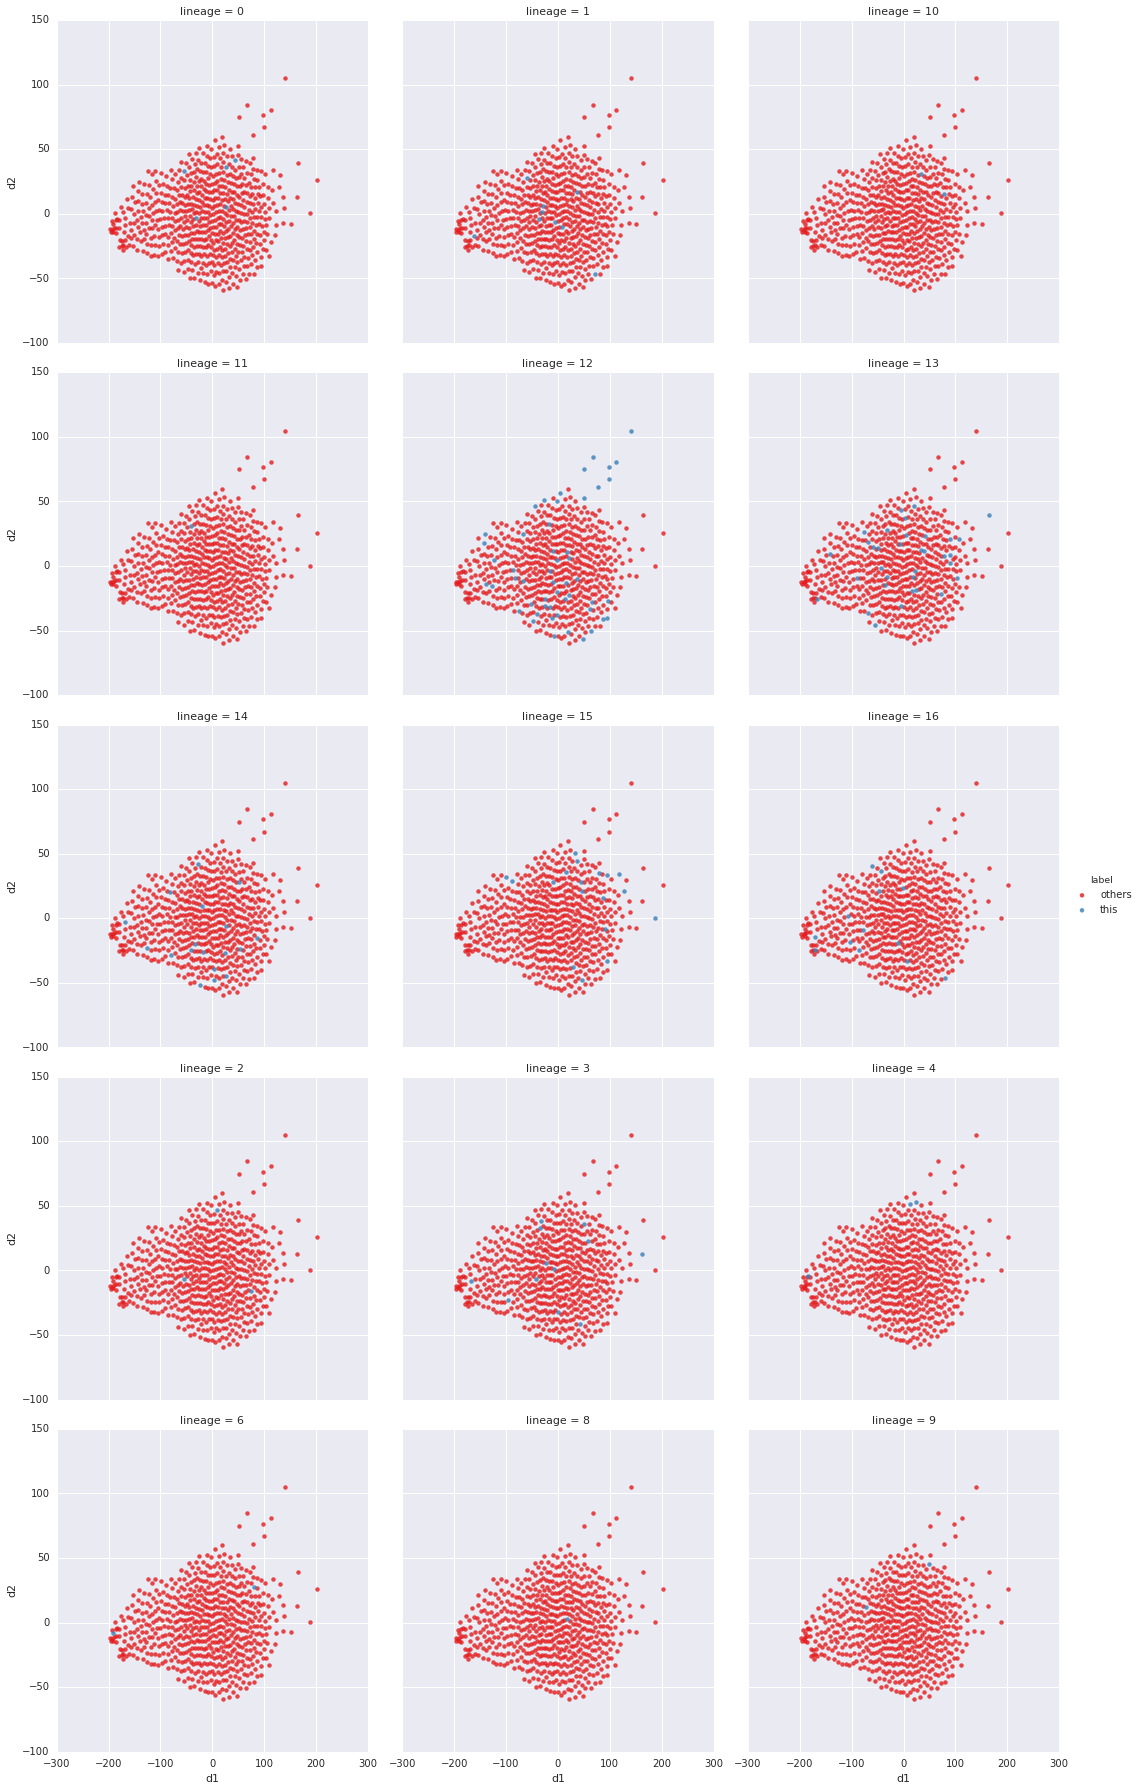

mean Silhouette Coefficient: -0.485990853396
P-value of Silhouette Coefficient: p= 0.57
### Isomap analasis ###


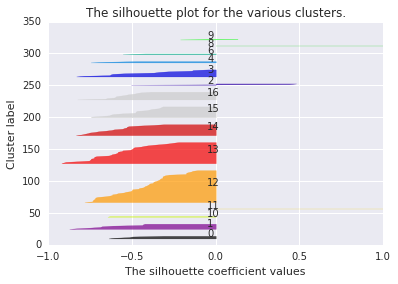

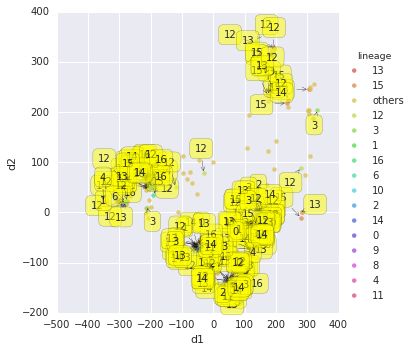

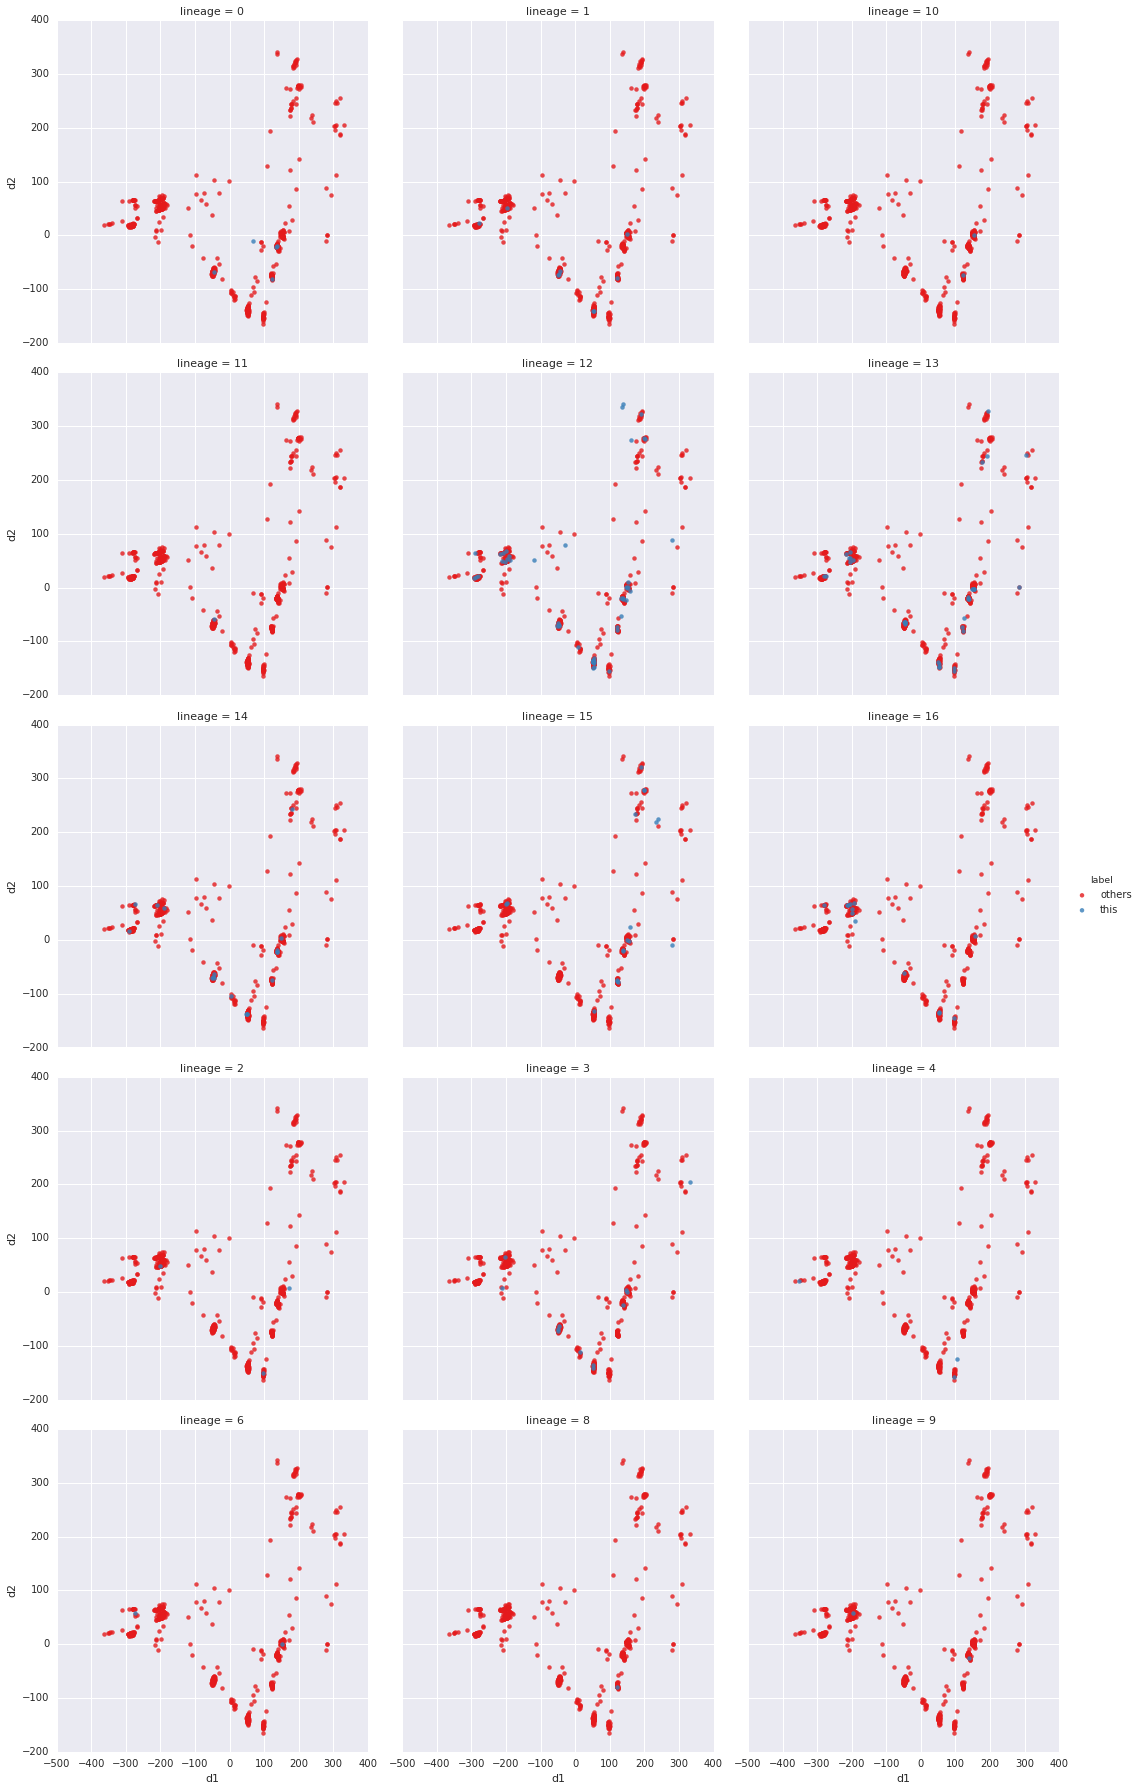

mean Silhouette Coefficient: -0.565721420148
P-value of Silhouette Coefficient: p= 0.315


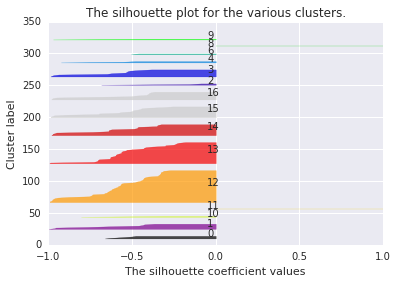

In [53]:
PCAanalysis(expr_data_allelic['mESC_trans_time1_rep2'])

##### PCA analysis on time point 1 （top genes,allelic)

Top contributors of the 1 PC
['Slc7a6' 'Zyx' 'Csrp1' 'Pmepa1' 'Reep5' 'Gpx3' 'Mfsd1' 'Ggta1' 'Commd3'
 'Cers2' 'Cald1' 'Wars' 'Me1' 'Atp6ap2' 'Jam3' 'Lpp' 'Pdlim7' 'Slc35f5'
 'Ifi30' 'Cnppd1' 'Amotl2' 'Plod2' 'Ckap4' 'S100a10' 'Ctsb' 'Arl4c'
 'Txndc12' 'F2r' 'Gm10775' 'Nefl' 'Dcaf12l1' 'Podxl' 'Gpc3' 'Hspg2' 'Apoe'
 'Sgpl1' 'Ddah1' 'Cstb' 'Soat1' 'Lamc1' 'Cst3' 'Lama1' 'Dab2' 'Tax1bp3'
 'Lamb1' 'Tpm1' 'Lrp2' 'Ctsl' 'Serpinh1' 'Sparc']
Saved to pc0_top50gene.txt
Top contributors of the 2 PC
['Lamb1' 'Arl4c' 'Msi1' 'Xbp1' 'Ifi30' 'Ggta1' 'Vcan' 'Glmp' 'Armcx2'
 'Gli3' 'Trp53i11' 'Id2' 'Dbn1' 'Limd2' 'Perp' 'Mfsd1' 'Kcnj3' 'Vrtn'
 'Cystm1' 'B4galt1' 'Serpinh1' 'Pdlim7' 'Bach1' 'Sat1' 'Gm10750' 'Abca13'
 'Sirt2' 'Gap43' 'Smim14' 'Fbxo15' 'Apbb1ip' 'Hes6' 'Tmem47' 'Sox3' 'Cd63'
 'Necap2' 'Pls3' 'Fndc3c1' 'Dpp4' 'Cd24a' 'Kif1a' 'Atp6v0a1' 'Cotl1' 'Tbx3'
 'Ctns' 'Elf3' 'Cndp2' 'Tfpi' 'Lama1' 'Dab2']
Saved to pc1_top50gene.txt
### PCA analasis ###


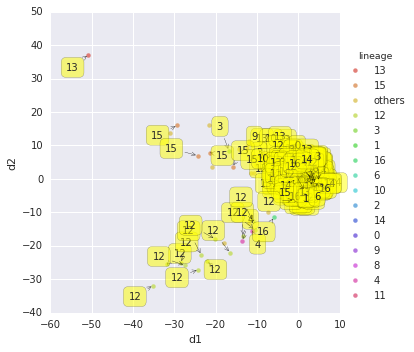

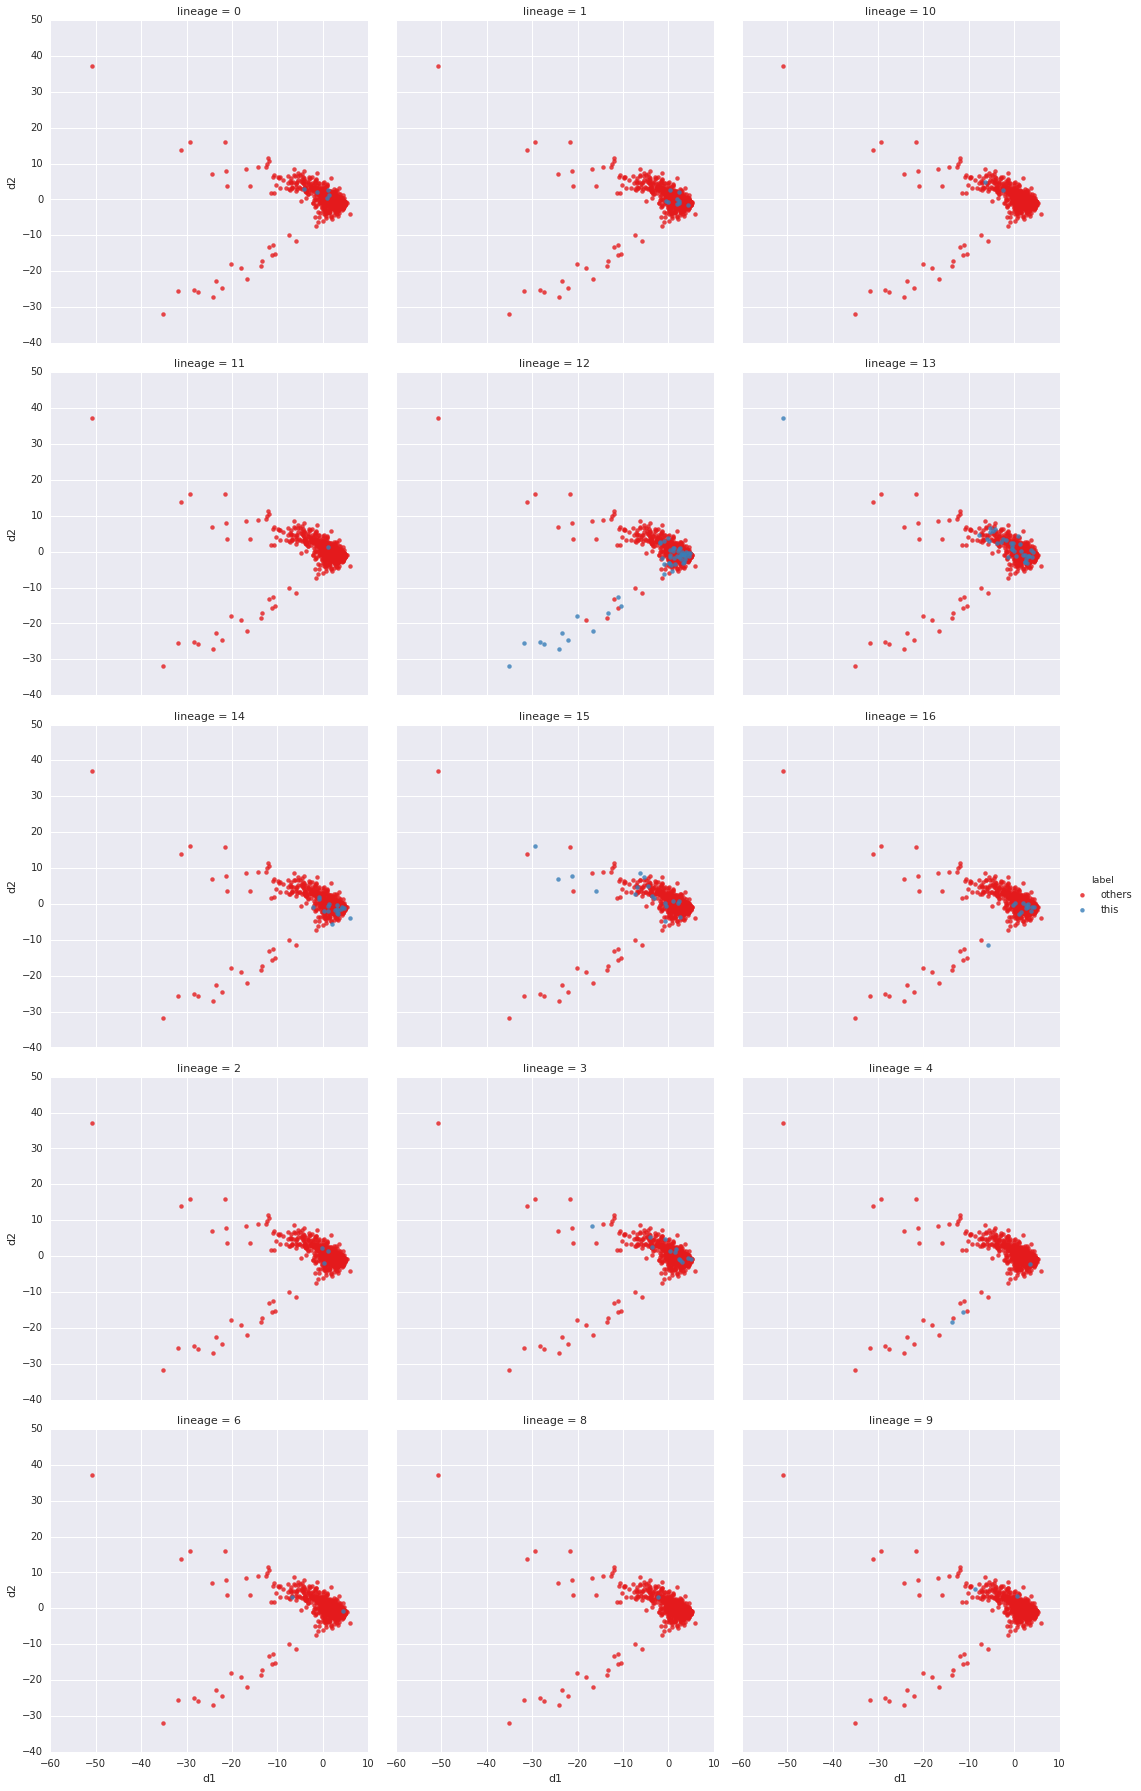

mean Silhouette Coefficient: -0.515058158972
P-value of Silhouette Coefficient: p= 0.022
### t-SNE analasis ###


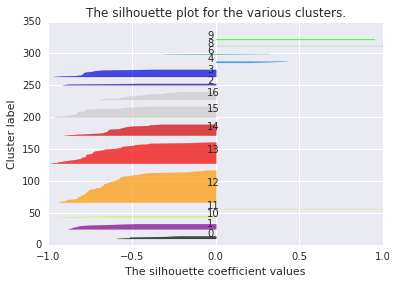

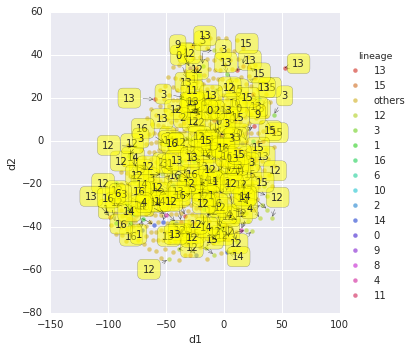

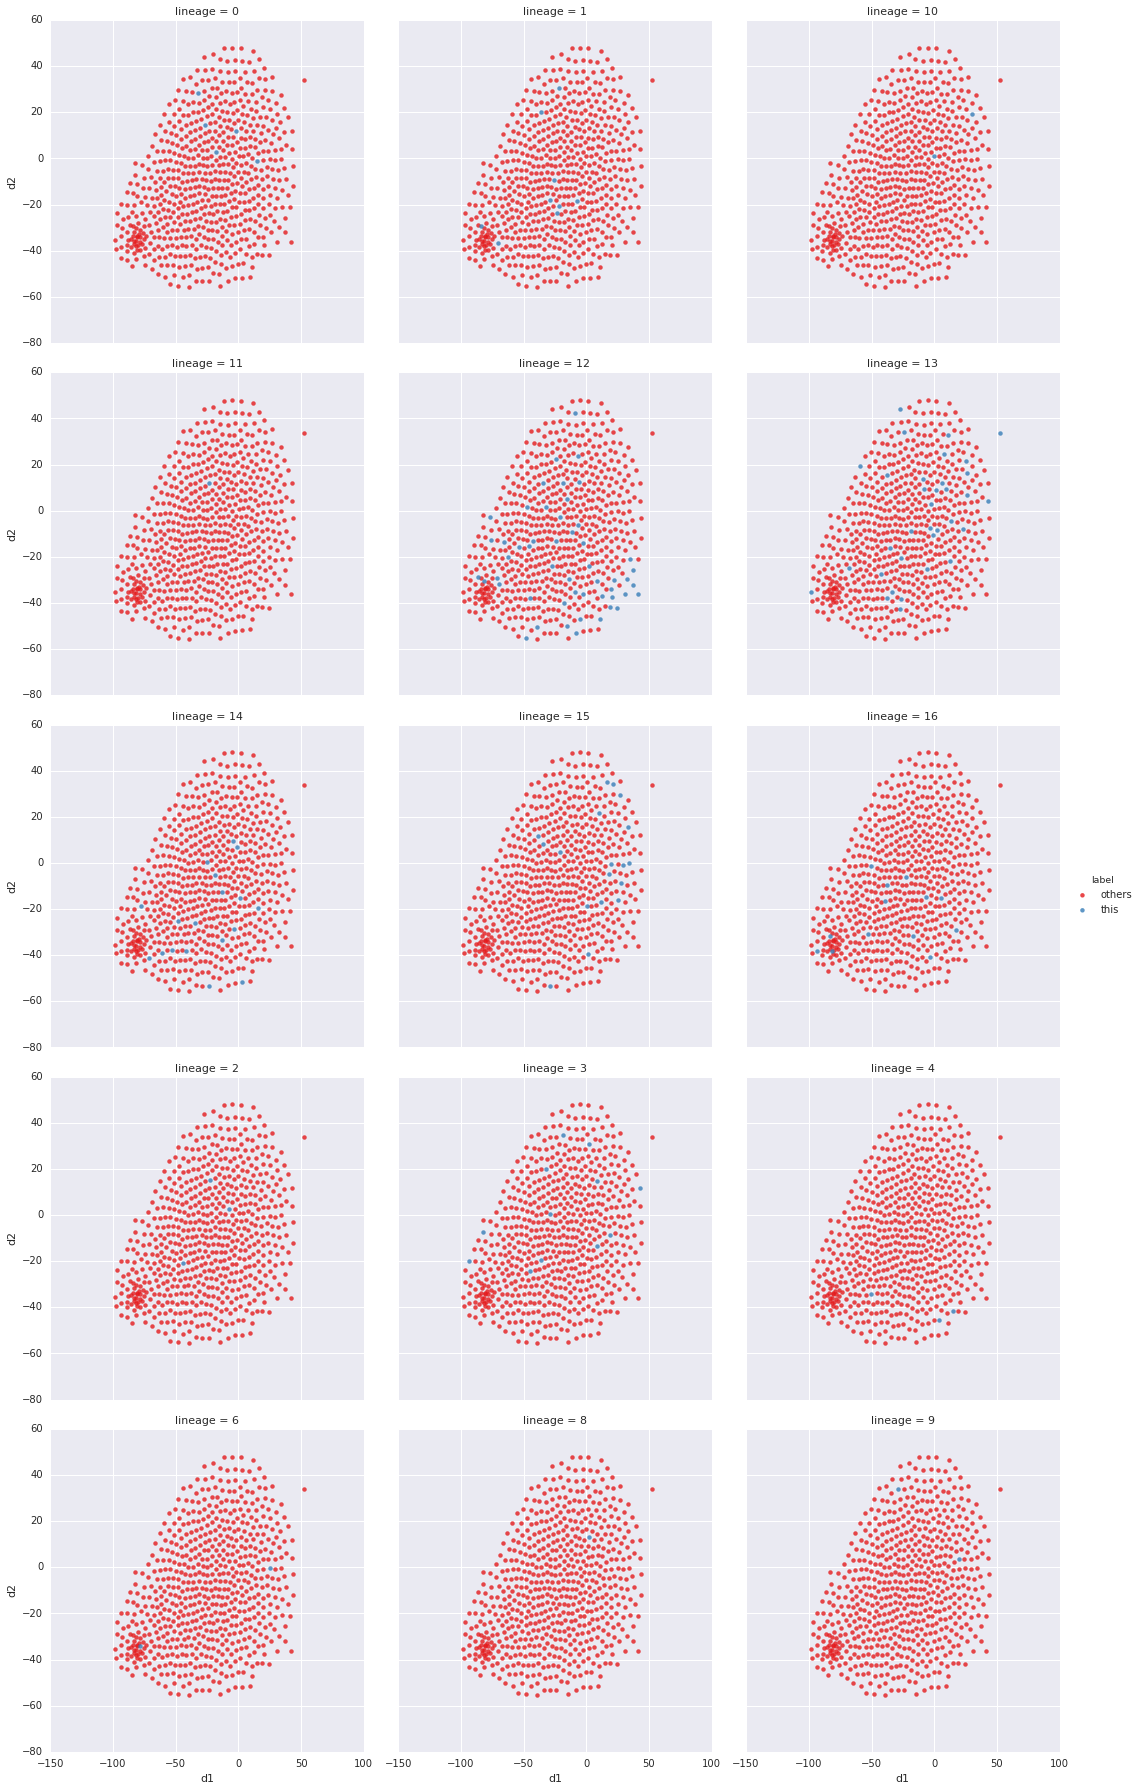

mean Silhouette Coefficient: -0.392777553601
P-value of Silhouette Coefficient: p= 0.084
### Isomap analasis ###


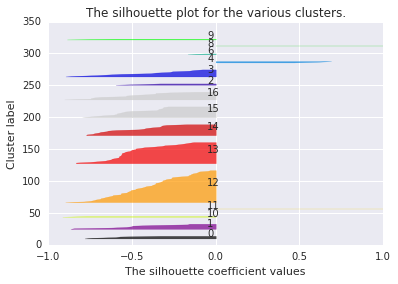

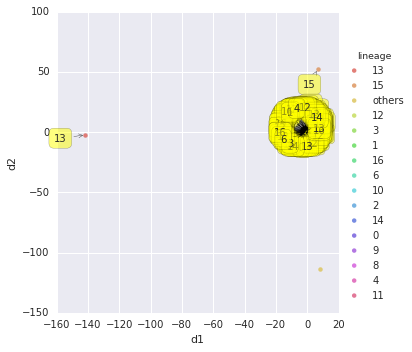

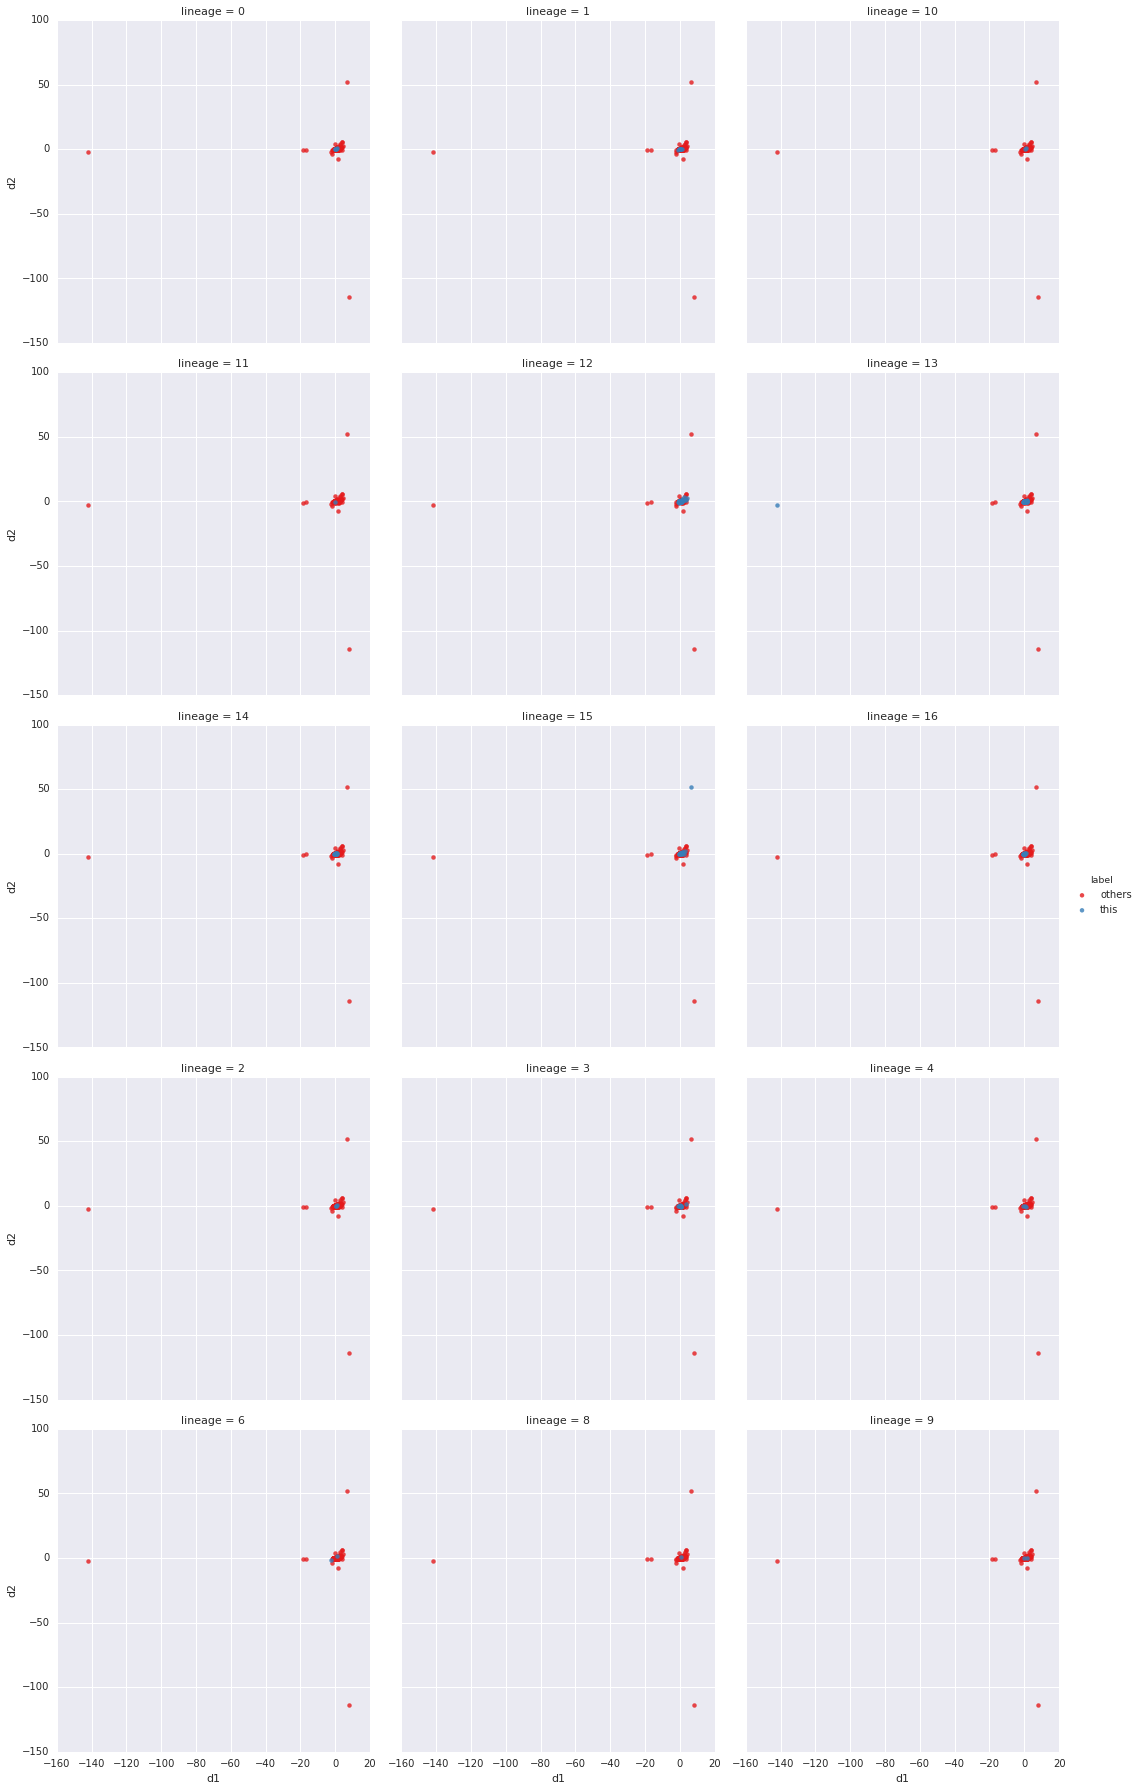

mean Silhouette Coefficient: -0.574846040298
P-value of Silhouette Coefficient: p= 0.356


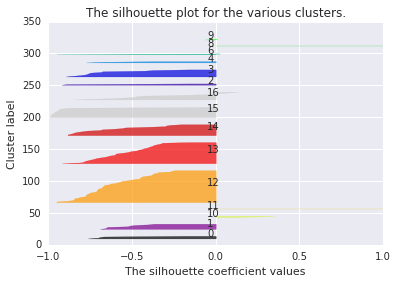

In [52]:
PCAanalysis(expr_data_allelic['mESC_trans_time1_rep2_top'])

##### PCA analysis on time point 2 （all genes,allelic)

Top contributors of the 1 PC
['1700057G04Rik' '1700042G07Rik' '4933402N22Rik' '4933405L10Rik'
 '1700019A02Rik' '4921513D11Rik' '4933406M09Rik' '4930415O20Rik'
 '1700011M02Rik' '4930444G20Rik' '1700049L16Rik' '1700019N19Rik'
 '1600014K23Rik' '4930432M17Rik' '4933402N03Rik' '4930579G24Rik'
 '1700001L19Rik' '4930415F15Rik' '1700029F12Rik' '4930402K13Rik'
 '1700020N01Rik' '1700028J19Rik' '1700034I23Rik' '4930505A04Rik'
 '2310034C09Rik' '4930474N05Rik' '4930480E11Rik' '1700084J12Rik'
 '1810022K09Rik' '4930595M18Rik' '1700016H13Rik' '4930407I10Rik'
 '4933402J07Rik' '2310057N15Rik' '4922502D21Rik' '1700026L06Rik'
 '1700001J03Rik' '1600014C23Rik' '4931414P19Rik' '1700011L22Rik'
 '1700007B14Rik' '1700001J11Rik' '1700012A03Rik' '1700011I03Rik'
 '1700012B09Rik' '1500009C09Rik' '1600029O15Rik' '1600002K03Rik'
 '1110032F04Rik' '1110008P14Rik']
Saved to pc0_top50gene.txt
Top contributors of the 2 PC
['Olfr902' 'Akr1c6' 'Slc6a8' 'Zbtb12' 'Klhl15' 'Taf13' 'Acsm2' 'Golph3l'
 'Acsf2' 'Itga2b' 'Pou5f2' '

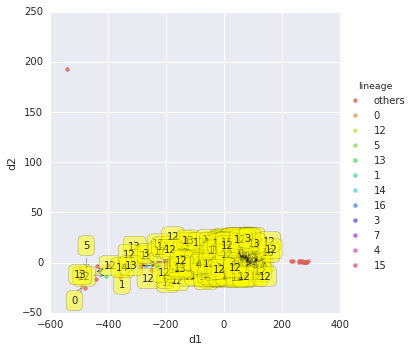

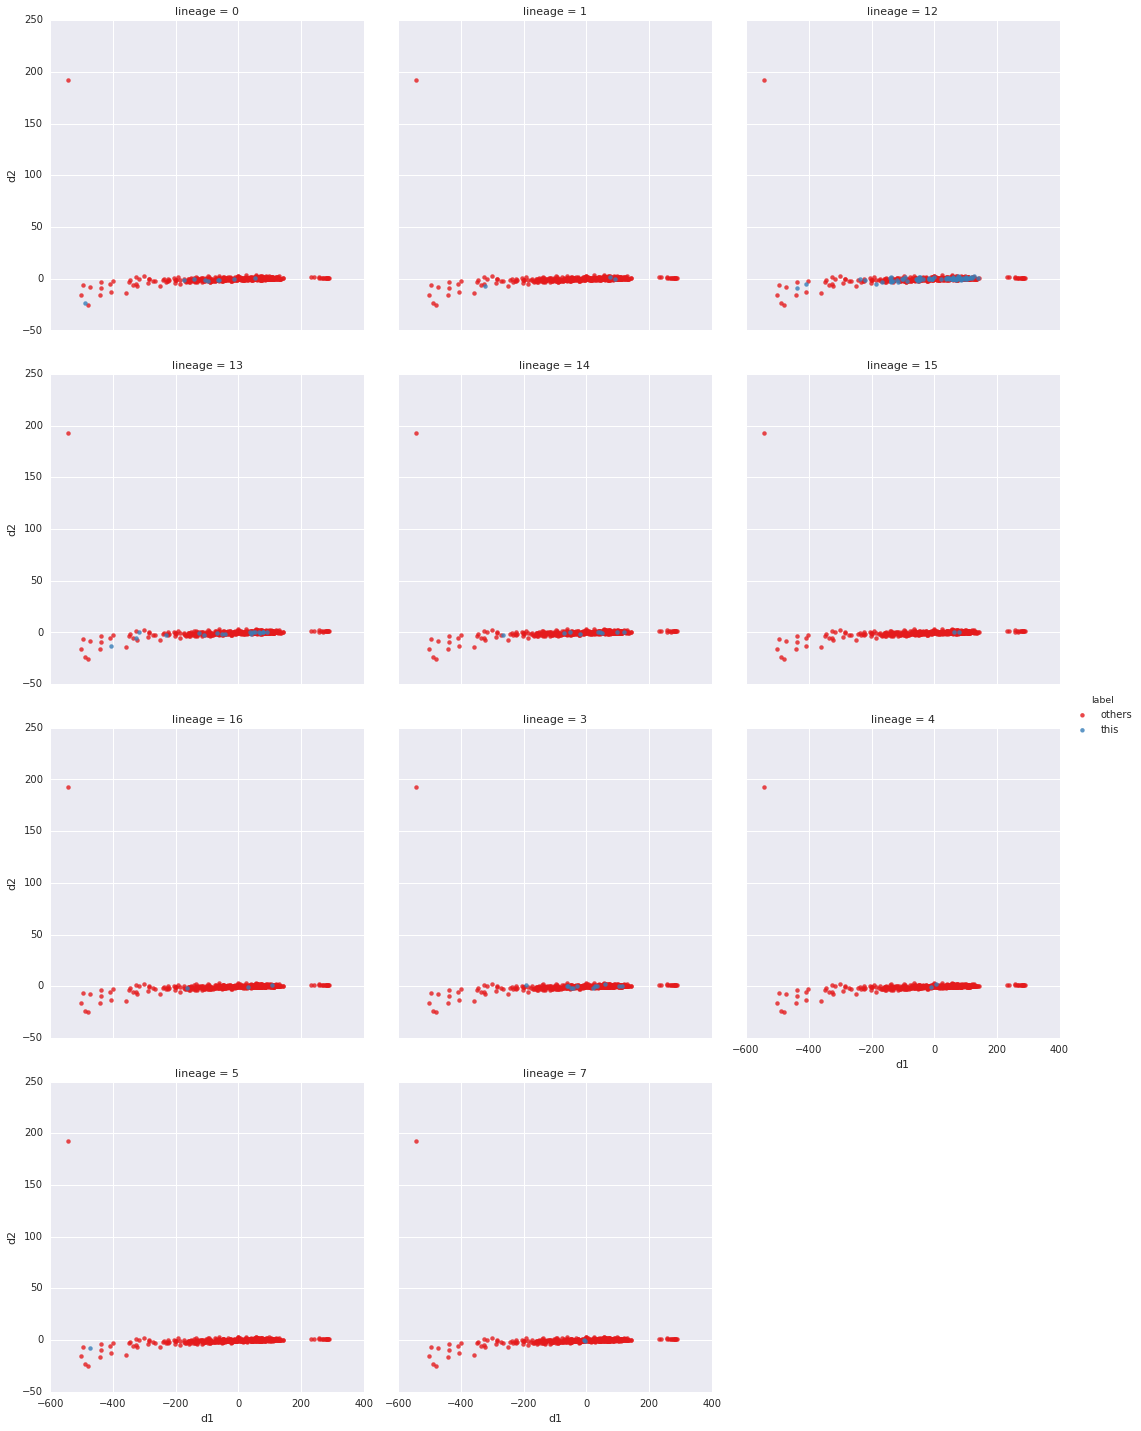

mean Silhouette Coefficient: -0.593337609394
P-value of Silhouette Coefficient: p= 0.52
### t-SNE analasis ###


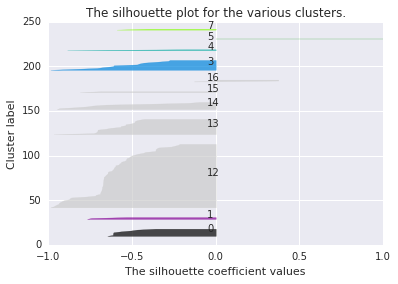

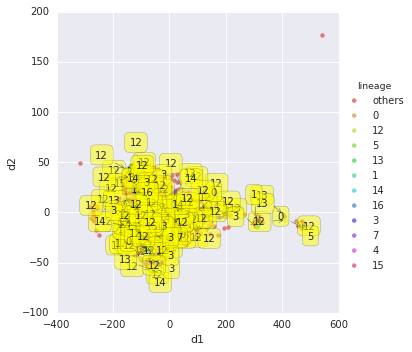

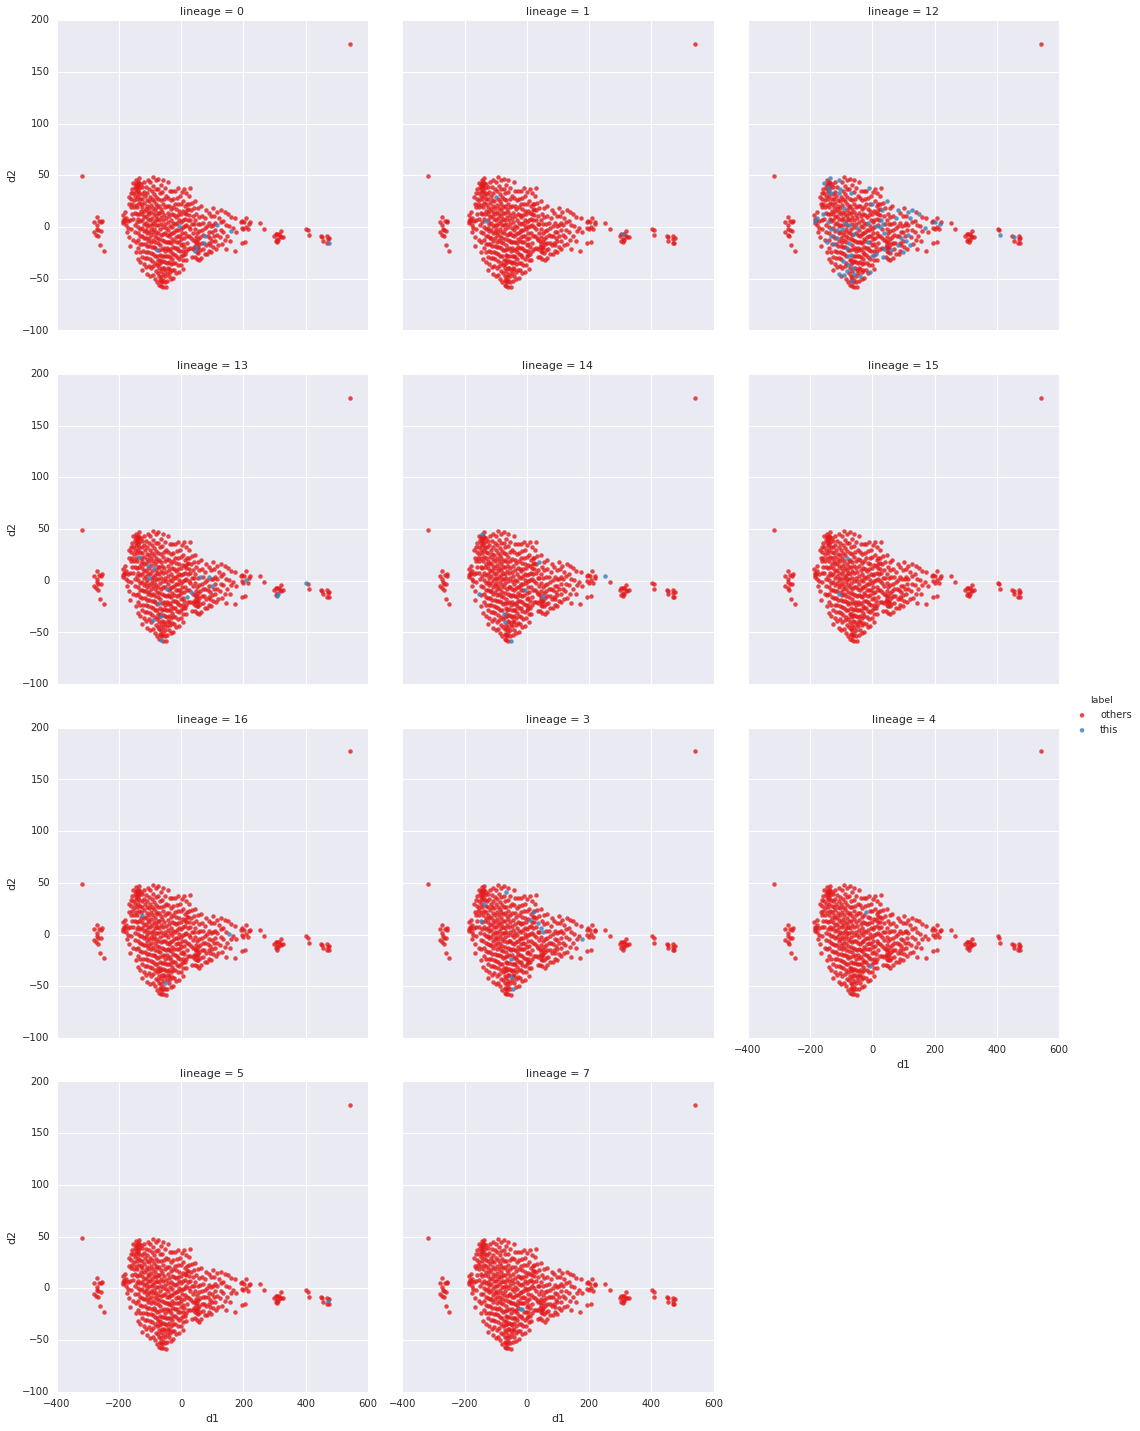

mean Silhouette Coefficient: -0.516006582052
P-value of Silhouette Coefficient: p= 0.497
### Isomap analasis ###


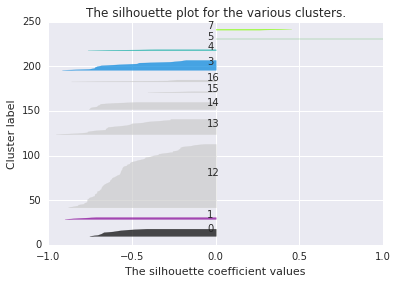

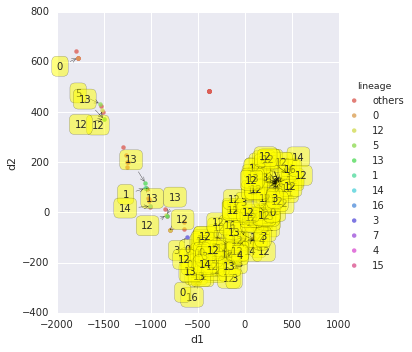

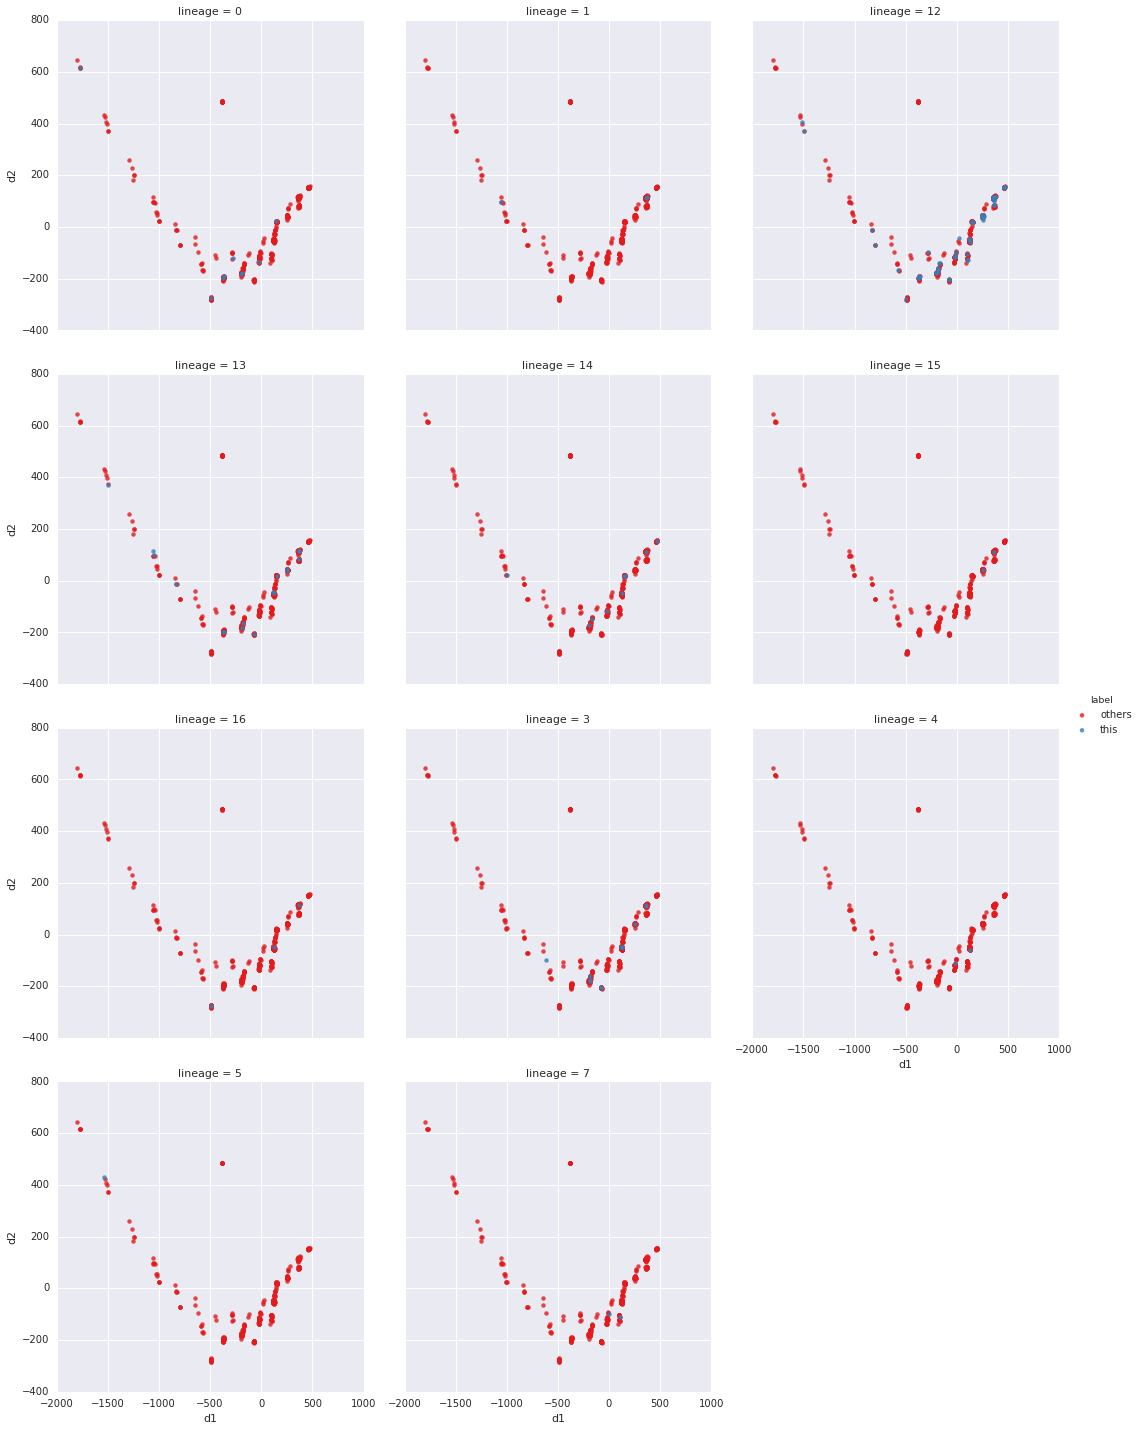

mean Silhouette Coefficient: -0.580047080723
P-value of Silhouette Coefficient: p= 0.485


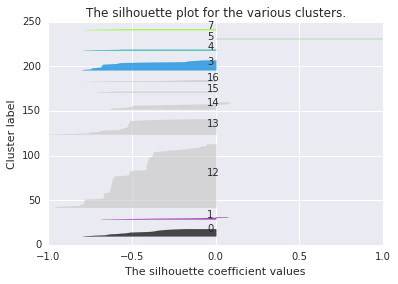

In [54]:
PCAanalysis(expr_data_allelic['mESC_trans_time2_rep2'])

##### PCA analysis on time point 2 （top genes,allelic)

Top contributors of the 1 PC
['Eif4g1' 'Ngfrap1' 'Sall4' 'Ywhab' 'Srm' 'Mapk1' 'Nasp' 'Sox2' 'Tuba1a'
 'Lman2' 'Dynll1' 'Stmn2' 'Ap2m1' 'Fhl1' 'Dnajc9' 'Pdap1' 'Capns1' 'Ryk'
 'P4hb' 'Gap43' 'Src' 'Myl12a' 'Rbms1' 'Ptms' 'Cd59b' 'Map1b' 'Msn' 'Flna'
 'Zwint' 'Car2' 'Ssbp3' 'Dppa5a' 'Apela' 'Anxa3' 'Sptbn1' 'Csrp1' 'Myadm'
 'Basp1' 'Chd4' 'Itgb1' 'Thbs1' 'S100a6' 'Scd2' 'Hspb1' 'Ahnak' 'Tmsb4x'
 'Igf2' 'Actn1' 'Tagln' 'Krt8']
Saved to pc0_top50gene.txt
Top contributors of the 2 PC
['Ap2a2' 'Eif4ebp1' 'Eif4g2' 'Cep170b' 'Stip1' 'Coro1c' 'Hint1' 'Mtap'
 'Ctnna1' 'Sec31a' 'Srsf11' 'Atp5g3' 'Gbp2' 'Eif4e' 'Nasp' 'Nars' 'Cadm1'
 'Hnrnpa0' 'Rab14' 'Txn-ps1' 'Cdk1' 'Fus' 'Fscn1' 'Gab1' 'Gap43' 'Cks1b'
 'Manf' 'Tuba1a' 'Oaz1' 'Kcmf1' 'Mest' 'Fn1' 'Nras' 'Eprs' 'Pim1' 'Kif23'
 'Max' 'Eif1' 'Top2a' 'Lrrfip1' 'Trim28' 'Tmsb10' 'Anapc11' 'mt-Nd4l'
 'Vdac1' 'Phf5a' 'Ube2d2a' 'Idi1' 'Chmp4b' 'Mtch1']
Saved to pc1_top50gene.txt
### PCA analasis ###


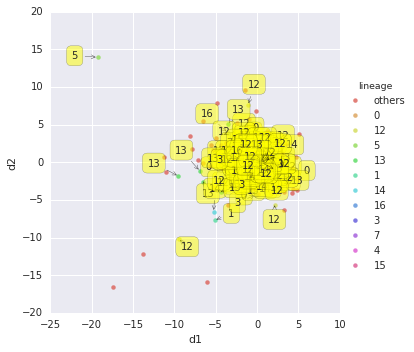

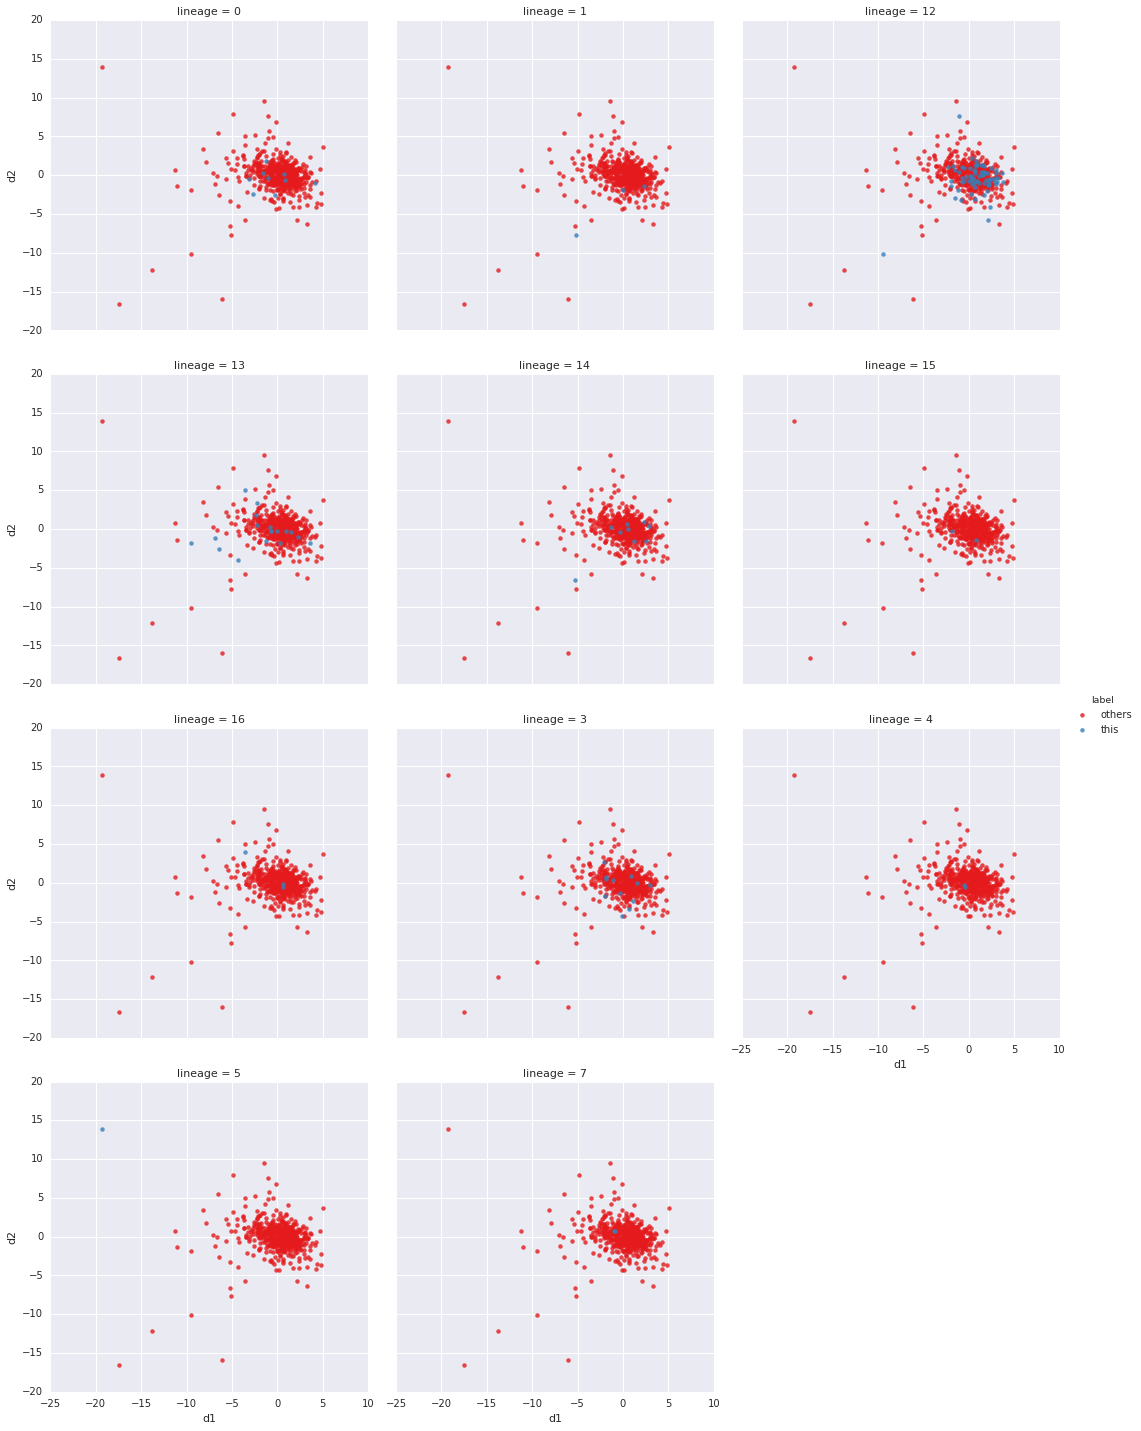

mean Silhouette Coefficient: -0.308084651864
P-value of Silhouette Coefficient: p= 0.009
### t-SNE analasis ###


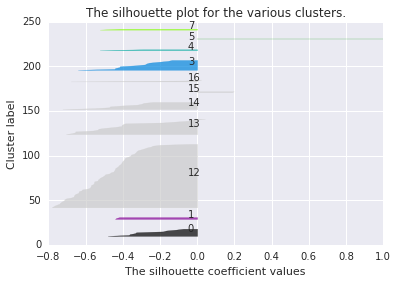

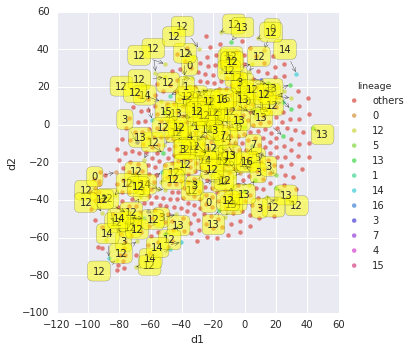

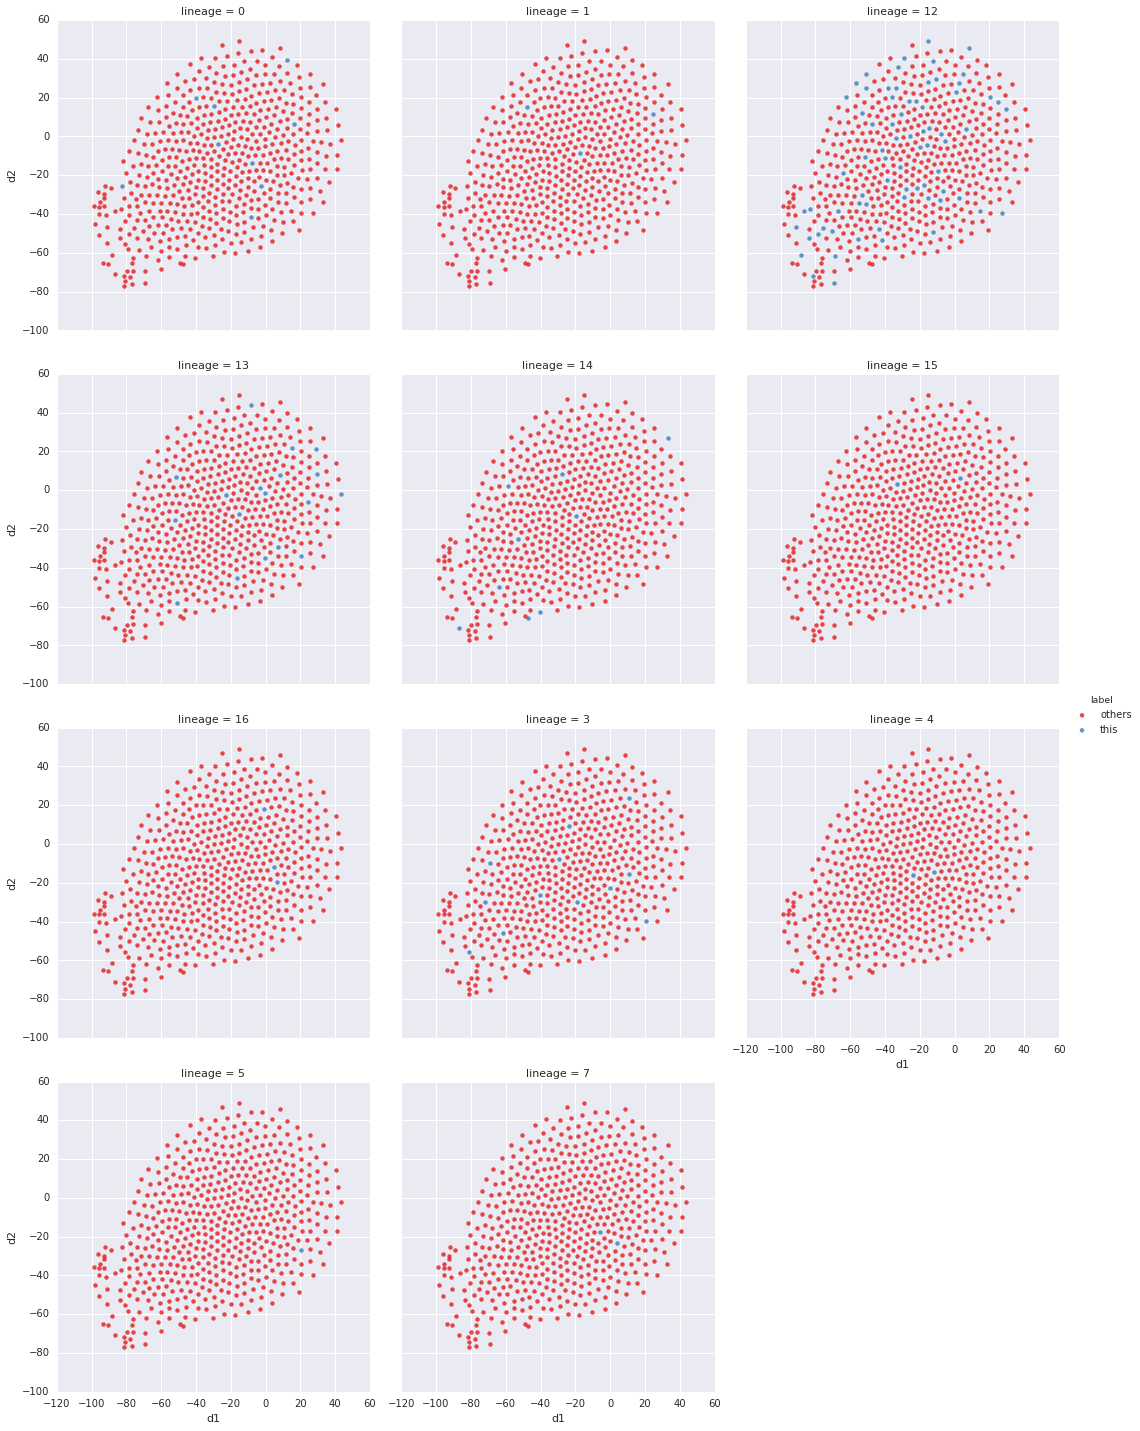

mean Silhouette Coefficient: -0.402699874442
P-value of Silhouette Coefficient: p= 0.429
### Isomap analasis ###


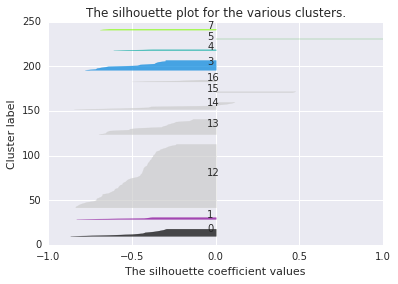

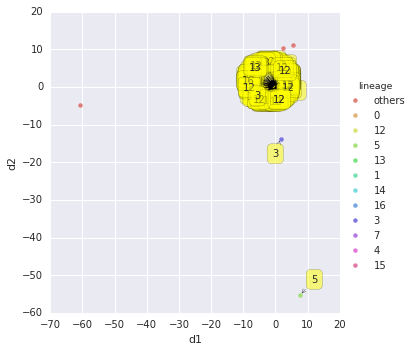

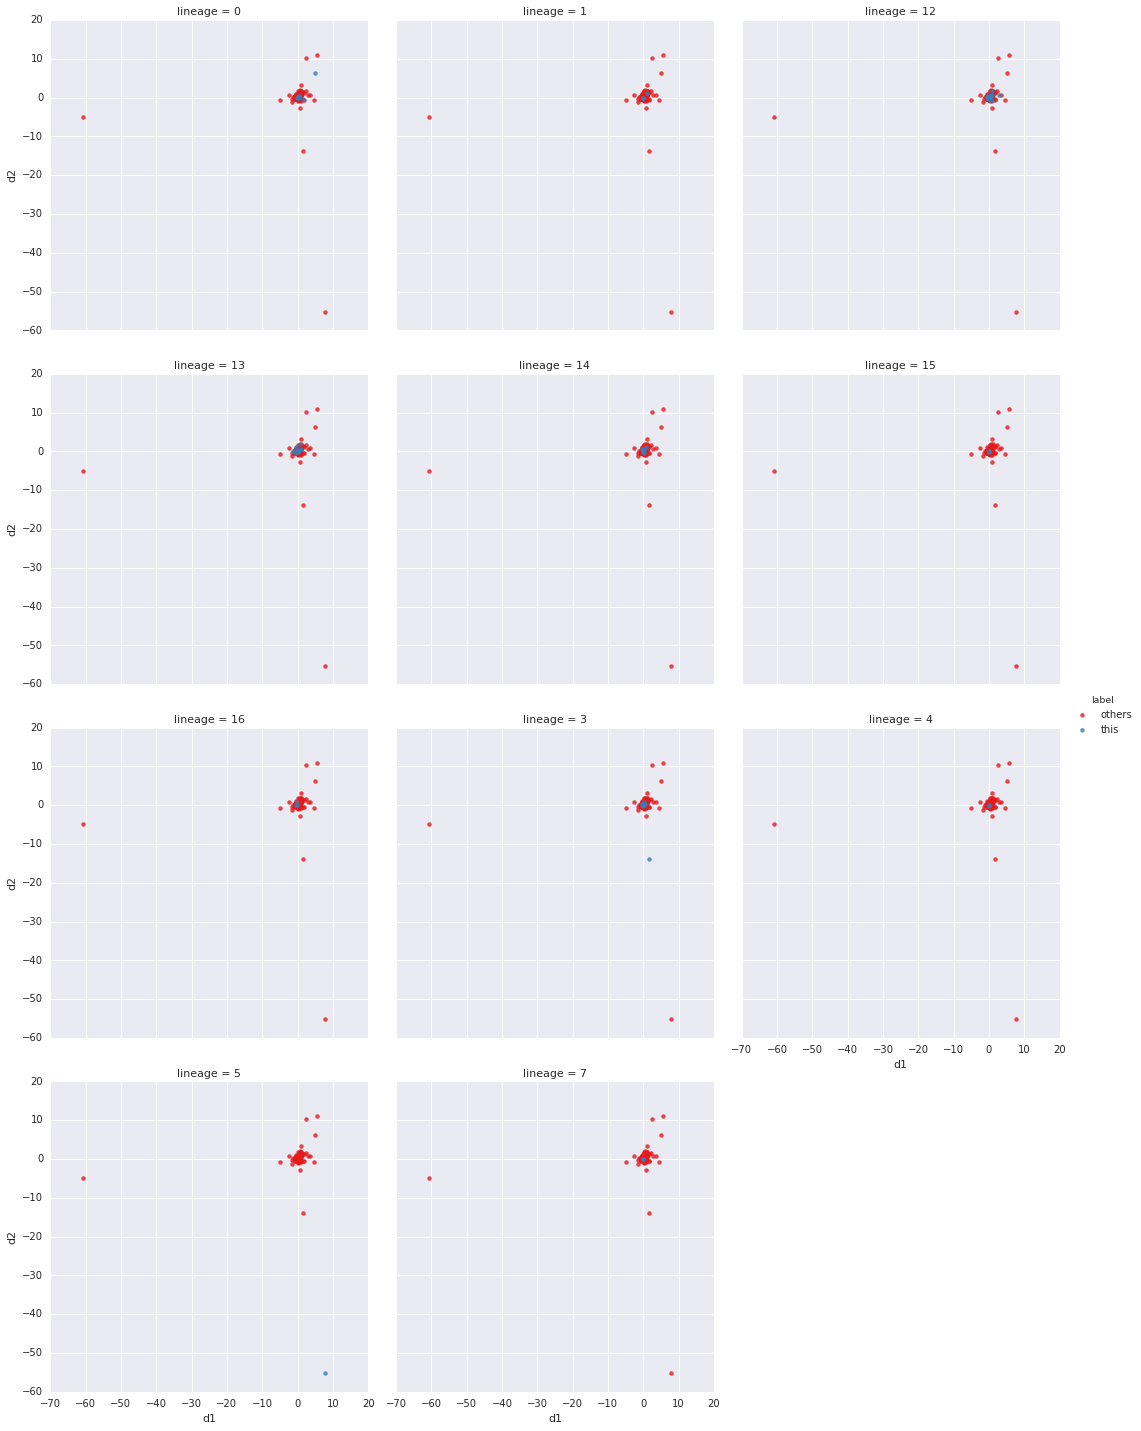

mean Silhouette Coefficient: -0.50846308405
P-value of Silhouette Coefficient: p= 0.044


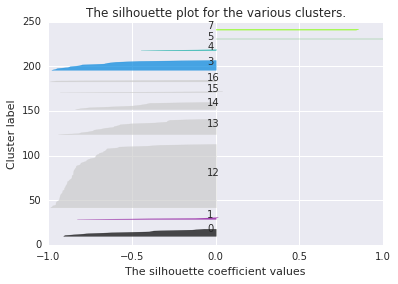

In [55]:
PCAanalysis(expr_data_allelic['mESC_trans_time2_rep2_top'])